In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:99% !important; }</style>"))

/tmp/ipykernel_4145/956813560.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [ ]:
%matplotlib inline
#%config InlineBackend.figure_format = 'retina'
%load_ext autoreload

%autoreload 2

import numpy as np

import matplotlib
matplotlib.rcParams.update({'font.size': 19})

import matplotlib.pyplot as plt
import os, glob, json
import scipy.linalg as sl
import enterprise
from enterprise.pulsar import Pulsar
import enterprise.signals.parameter as parameter
from enterprise.signals import utils
from enterprise.signals import signal_base
from enterprise.signals import selections
from enterprise.signals.selections import Selection
from enterprise.signals import white_signals
from enterprise.signals import gp_signals
from enterprise.signals import deterministic_signals
import enterprise.constants as const

import enterprise_extensions
from enterprise_extensions import blocks

from QuickBurst import QuickBurst_MCMC as QB_MCMC

import healpy as hp

import libstempo as T2
import libstempo.toasim as LT
import libstempo.plot as LP
import re

import pickle

from QuickBurst import tau_scans_pta

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Setup

In [ ]:
parDir = '/home/mitch/test_quick_burst/20_pulsars/WN_only/Pars/'
timDir =  "/home/mitch/test_quick_burst/20_pulsars/WN_only/Tims/"

parfiles = sorted(glob.glob(parDir + '*.par'))
timfiles = sorted(glob.glob(timDir + "*.tim"))
psrs = []
for p, t in zip(parfiles, timfiles):
    psr = Pulsar(p, t, ephem=None, clk=None)
    psrs.append(psr)

[]
[tempo2Util.C:396] Warning: [TIM1] Please place MODE flags in the parameter file 


[tempo2Util.C:401] Warning: [DUP1] duplicated warnings have been suppressed.


In [4]:
'''can save generated pulsars as a pickle for future use'''
# pkl_path = "/home/user/filepath.../"
# os.makedirs(pkl_path,exist_ok=True)
# with open(pkl_path + "Psrs_pkl.pkl", 'wb') as f: #_old_pars
#     pickle.dump(psrs, f)

In [ ]:
'''Load in pulsar pickle files'''
# pkl_path = "home/user/filepath.../"
# with open(pkl_path + "Psrs_pkl.pkl", 'rb') as f:
#     psrs = pickle.load(f)

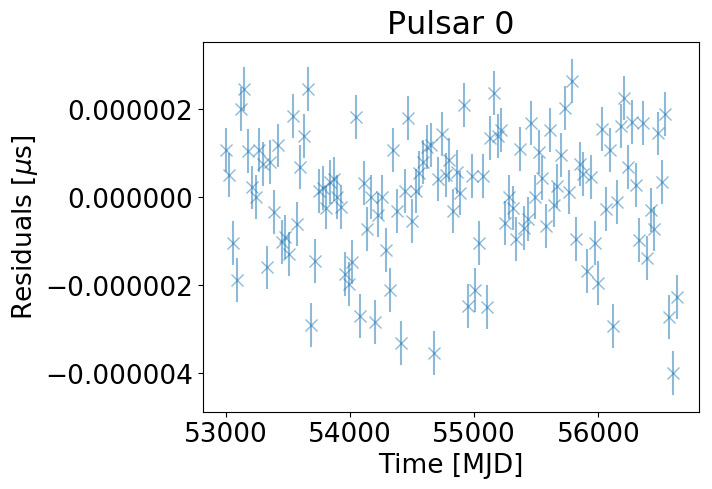

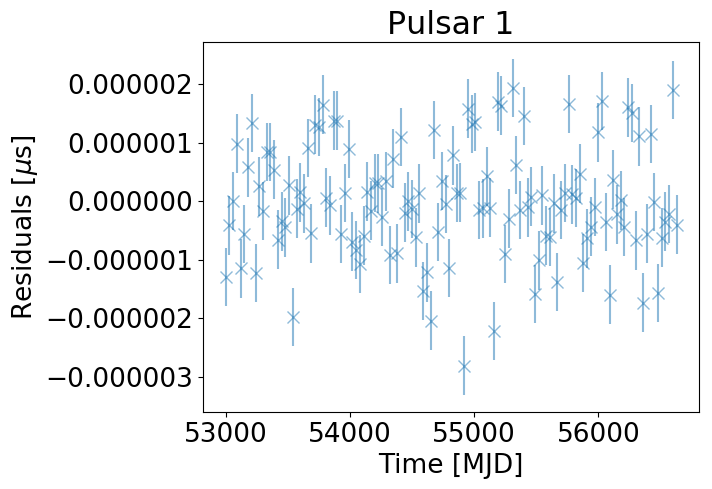

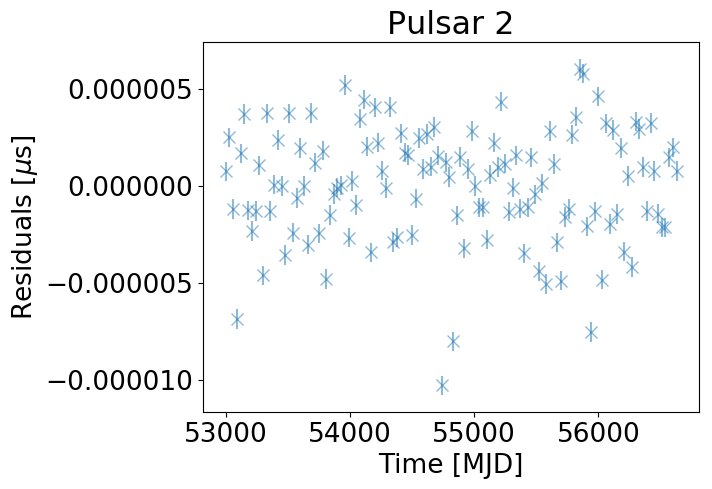

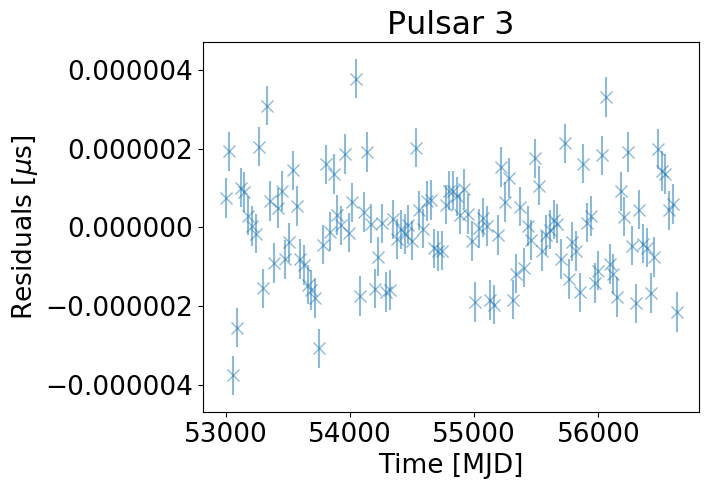

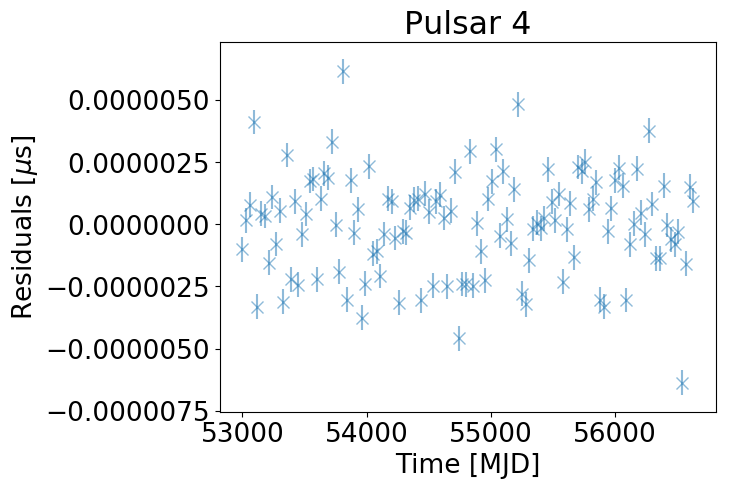

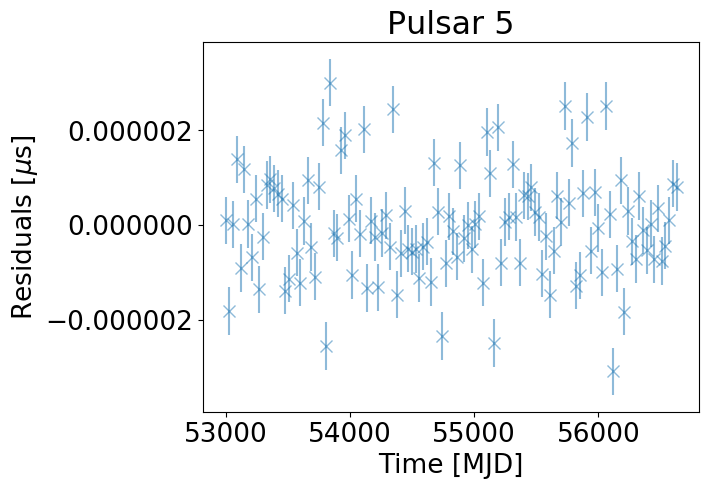

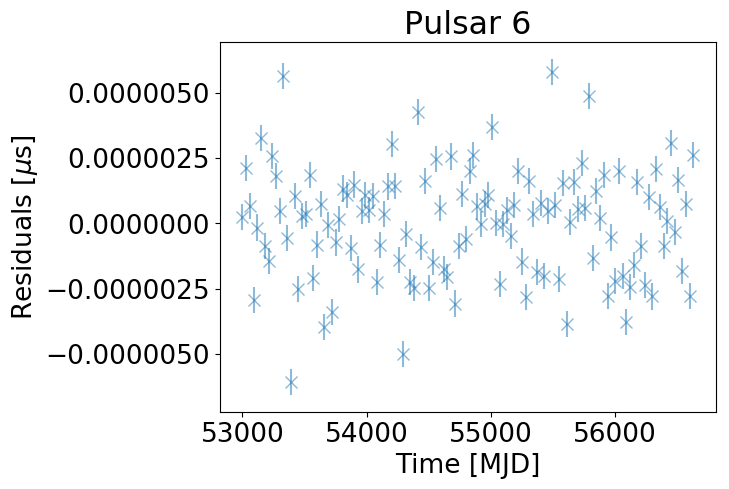

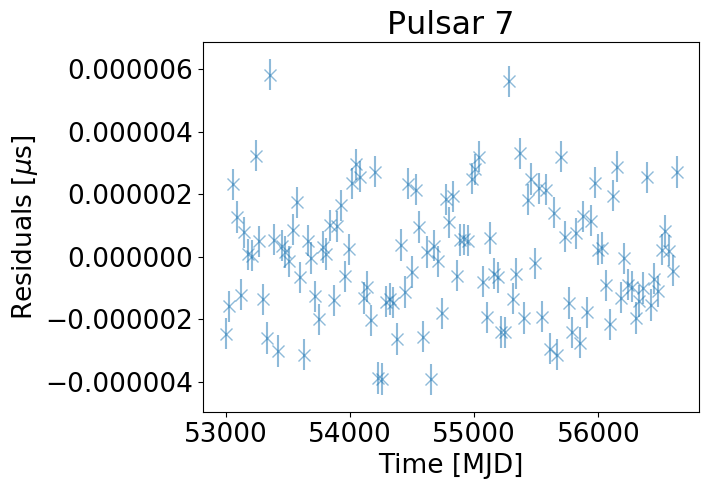

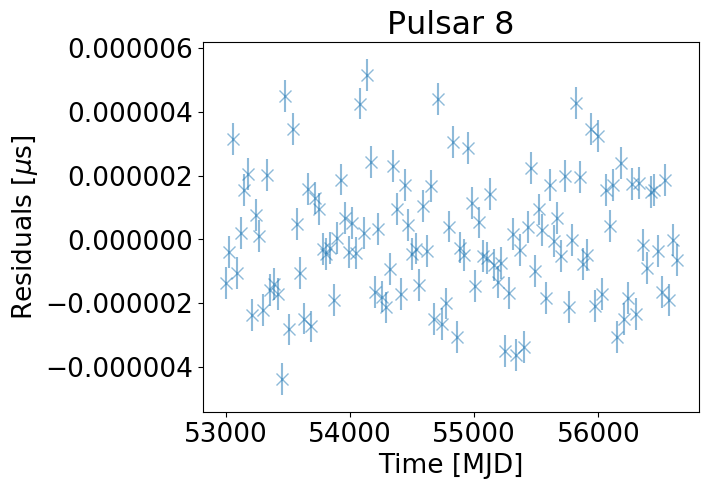

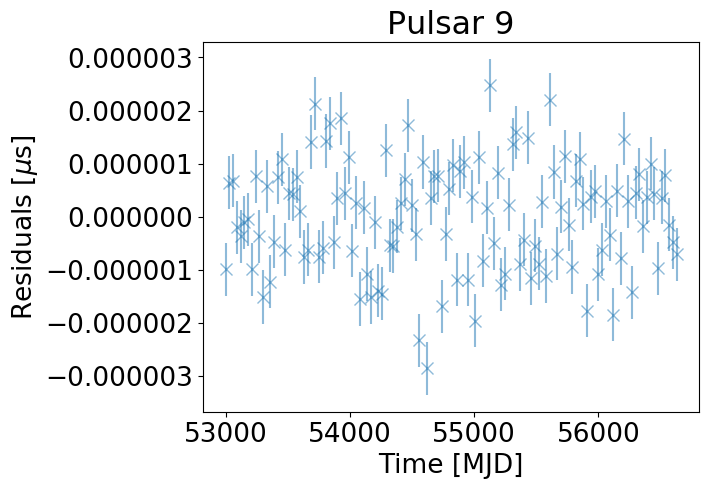

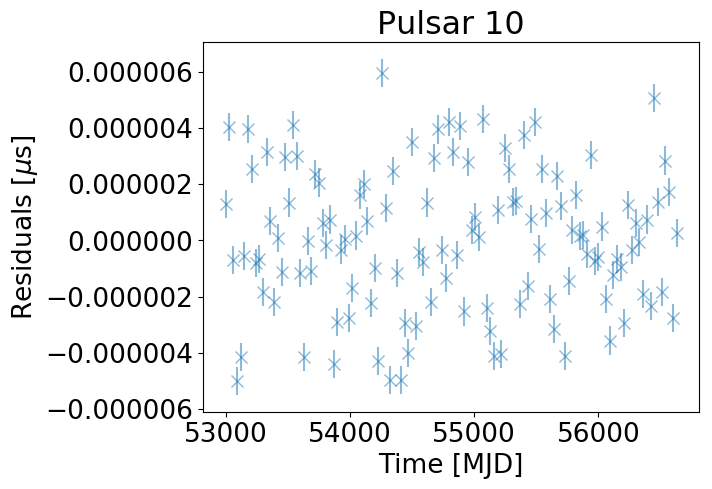

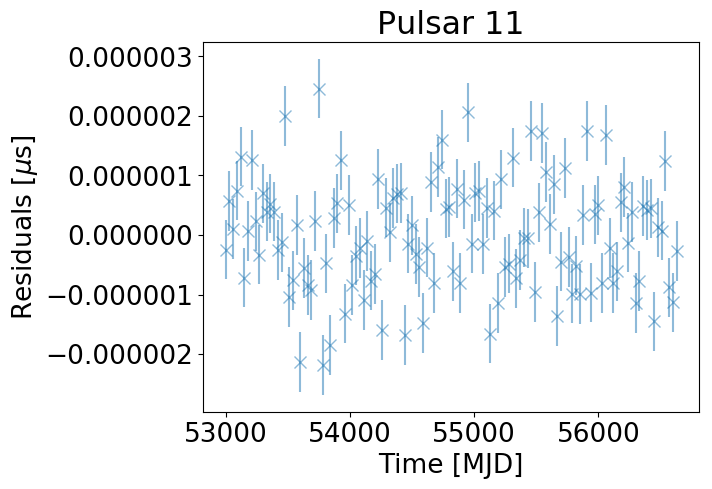

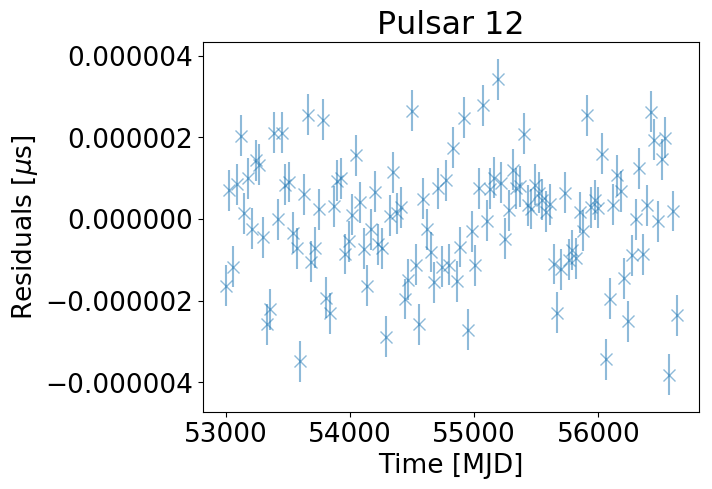

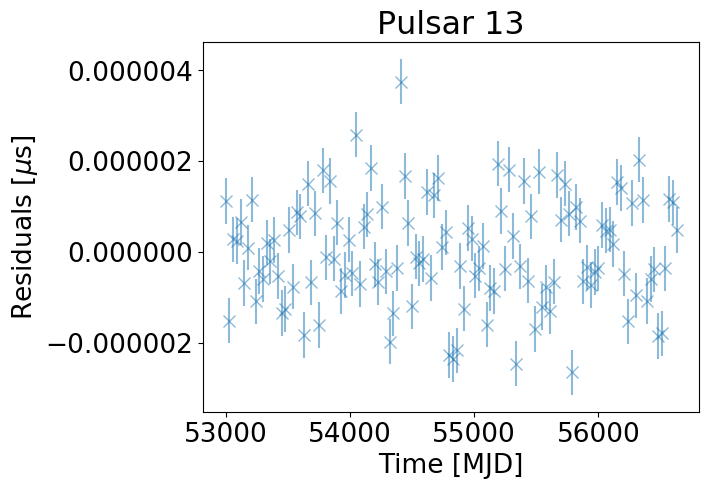

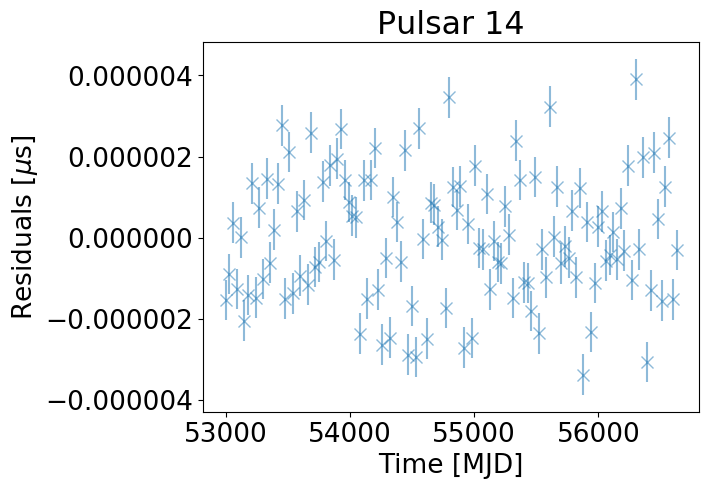

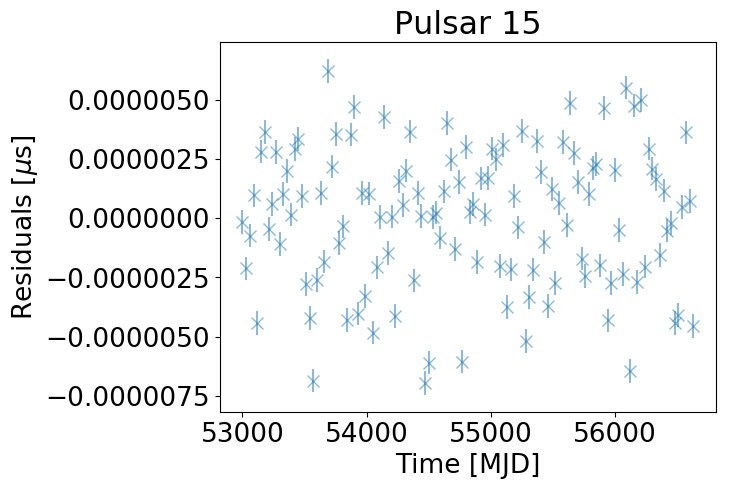

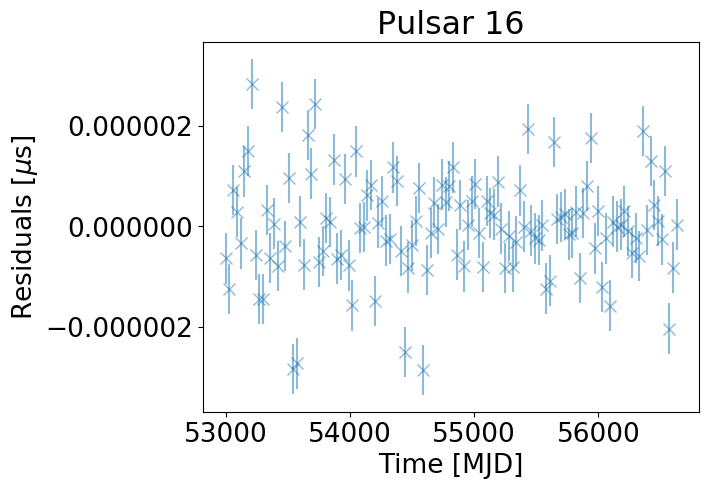

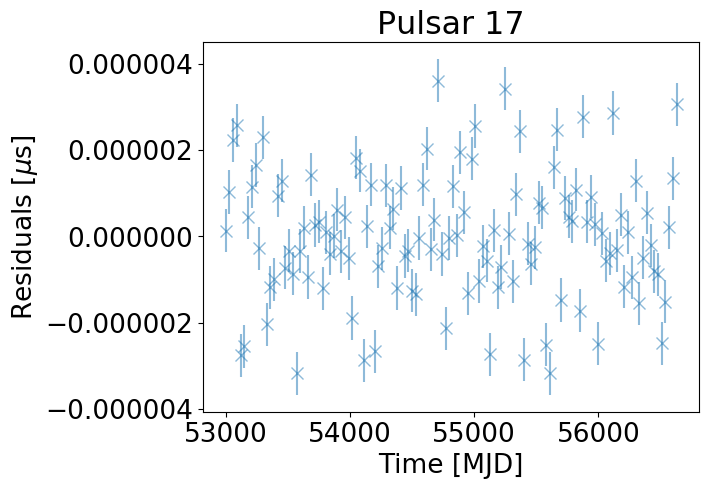

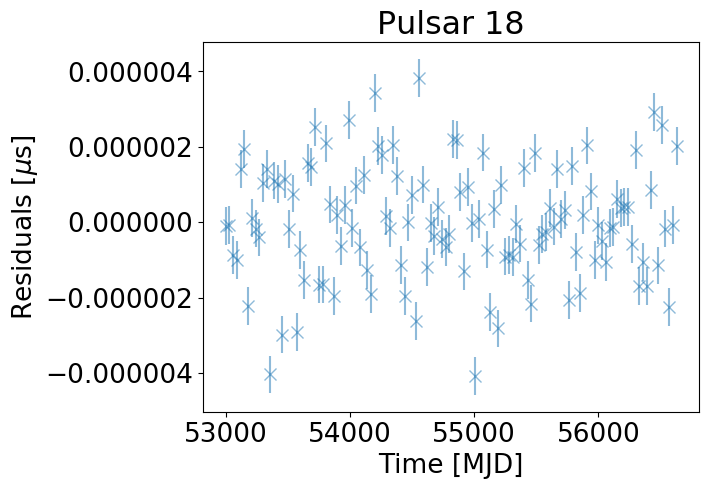

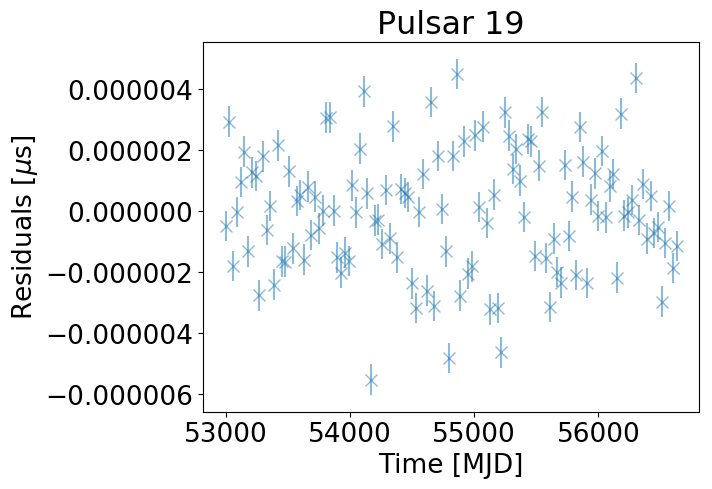

In [32]:
### Visualize data
for i, psr in enumerate(psrs):
    plt.figure(i)      
    plt.errorbar(psr.toas/86400,
            psr.residuals,
            yerr=0.5*10**(-6),#psr.toaerrs[mk],
            markersize=8, ls='', marker='x', alpha=0.5)
    plt.xlabel('Time [MJD]')
    plt.ylabel(r'Residuals [$\mu$s]')
    plt.title('Pulsar {}'.format(i))
    plt.show()

## generates shorted list of pulsars

In [5]:
#Truncate PTA based on Tspan > 10 years
keep_list = []
for p in psrs:
    if (p.toas.max()-p.toas.min())/86400/365 > 10:
        print(p.name)
        print((p.toas.max()-p.toas.min())/86400/365)
        keep_list.append(p)
print(len(keep_list))

0


In [21]:
# os.makedirs(pkl_path, exist_ok=True)
# with open(pkl_path + "Psrs_pkl_10yr.pkl", 'wb') as f:
#     pickle.dump(keep_list, f)

In [7]:
# with open("home/user/filepath.../Psrs_pkl_10yrs.pkl", 'rb') as f:
#     psrs = pickle.load(f)

In [13]:
#plotting for more complicated dataset pulsars
ng_frontends=['327', '430', 'Rcvr_800', 'Rcvr1_2', 'L-wide', 'S-wide', '1.5GHz', '3GHz']
for i, psr in enumerate(psrs):
    fe_masks = {}
    fe_resids = {}
    psr_fe = np.unique(psr.flags['fe'])
    resids = psr.residuals
    #plt.plot(psr.toas(),resids)
#     print(psr.name)
    plt.figure(i)
    for fe in ng_frontends:
        if fe in psr_fe:
            fe_masks[fe] = np.array(psr.flags['fe']==fe)
            mk = fe_masks[fe]
            plt.errorbar(psr.toas[mk],
                    psr.residuals[mk]*1e6,
                    yerr=0.0,#psr.toaerrs[mk],
                    markersize=8, ls='', marker='x', label=fe, alpha=0.5)
            plt.xlim(tref, maximum)
            plt.title(psr.name)
            #plt.axvline(psr.toas[0]+1423*(86400))
    plt.legend()
    plt.show()

KeyError: 'fe'

In [20]:
#load in noise file for dataset
noise_file = "../../20_pulsars/WN_only/noise_dict.json"
with open(noise_file, 'r') as h:
    noise_params = json.load(h)
    
### RUN IF INCLUDING CURN
# gw_gamma = ...
# gw_amp = ...
# noise_params['gw_crn_gamma'] = gw_gamma
# noise_params['gw_crn_log10_A'] = gw_amp

In [13]:
#Edit equad to have keys including 't2equad'
#only needed for converting 12.5yr data to current enterprise structure
noise_dict = {}
for k, v in noise_params.items():
    if 'equad' in k:
        noise_dict[k[:-5] + 't2equad'] = v
    else:
        noise_dict[k] = v
noise_params = noise_dict

In [23]:
#check noise parameters are what they should be
noise_dict=noise_params
noise_dict

{'JPSR00_efac': 1.8689379530521901,
 'JPSR01_efac': 2.059675826005349,
 'JPSR02_efac': 3.0748606945657295,
 'JPSR03_efac': 2.585580282428298,
 'JPSR04_efac': 1.306306353450894,
 'JPSR05_efac': 2.2773544810789987,
 'JPSR06_efac': 4.549380171029036,
 'JPSR07_efac': 4.219982666682523,
 'JPSR08_efac': 4.203481666382409,
 'JPSR09_efac': 2.0239824772557204,
 'JPSR10_efac': 4.8229400301325756,
 'JPSR11_efac': 1.8810720005787385,
 'JPSR12_efac': 2.7899938334974146,
 'JPSR13_efac': 2.239301276926412,
 'JPSR14_efac': 2.0720756835008314,
 'JPSR15_efac': 4.601274822894665,
 'JPSR16_efac': 2.1540371144986725,
 'JPSR17_efac': 3.32976374621823,
 'JPSR18_efac': 3.154554728980668,
 'JPSR19_efac': 4.022119621532103,
 'JPSR00_log10_t2equad': -5.969194645533057,
 'JPSR01_log10_t2equad': -6.685017179105907,
 'JPSR02_log10_t2equad': -5.626366465579119,
 'JPSR03_log10_t2equad': -7.718808126457086,
 'JPSR04_log10_t2equad': -5.670995915028478,
 'JPSR05_log10_t2equad': -7.2278321569508135,
 'JPSR06_log10_t2equa

# Individual glitch tau scans

In [26]:
#Finding reference time for dataset
maximum = 0
minimum = np.inf
for psr in psrs:
    if psr.toas.max() > maximum:
        maximum = psr.toas.max()
    if psr.toas.min() < minimum:
        minimum = psr.toas.min()


#Sets reference time
tref = minimum

t0_max = (maximum - minimum)/365/24/3600
print(t0_max)

9.945234130667314


In [ ]:
#frequency range (Hz)
f_max = 1e-7
f_min = 3.5e-9

#centrtal time range (years)
t_max = t0_max
t_min = 0.0

#tau range (envelope size, years)
tau_min = 0.2
tau_max = 5.0

In [27]:
#frequency of wave with a period equal to envelope width
1/(tau_max*365*24*3600)

6.341958396752917e-09

In [28]:
TS_all = {} #will hold individual pulsar Tau Scans
tau_scan = 0
for i in range(len(psrs)):
    # generate a pta for each pulsar individualy
    x = QB_MCMC.get_pta([psrs[i],], vary_white_noise=False, include_equad=True,
                            include_ecorr = False, include_efac = True, 
                            wn_backend_selection=False, noisedict=noise_dict, include_rn=False,
                            vary_rn=False, include_per_psr_rn=False, vary_per_psr_rn=False,
                            max_n_wavelet=5, efac_start = None, rn_amp_prior='log-uniform',
                            rn_log_amp_range=[-18,-11], per_psr_rn_amp_prior='log-uniform',
                            per_psr_rn_log_amp_range=[-18,-11], wavelet_amp_prior='uniform',
                            wavelet_log_amp_range=[-10.0,-5], prior_recovery=False,
                            max_n_glitch=1, glitch_amp_prior='uniform', glitch_log_amp_range=[-10.0,-5],
                            t0_min=0.0, t0_max=t0_max, f0_min=f_min, f0_max=f_max,
                            TF_prior=None, tref=tref)

    #Performs tau scans for each pulsar individually (noise transients)

    TauScan = tau_scans_pta.TauScan([psrs[i],], params=noise_params, pta=x[0])
    TS_dict = tau_scans_pta.make_tau_scan_map(TauScan, f_min=f_min, f_max=f_max, t_min=t_min, t_max=t_max,
                                tau_min=tau_min, tau_max=tau_max)
    TS_all['tau_edges'] = TS_dict['tau_edges'] #why saved every time?
    TS_all['t0_edges'] = TS_dict['t0_edges']
    TS_all['f0_edges'] = TS_dict['f0_edges']
    TS_all['tau_scan'+str(i)] = TS_dict['tau_scan']

Number of params per pulsar:  [0]
1  /  5
5
80
SUM:  400
2  /  5
11
42
SUM:  462
3  /  5
21
22
SUM:  462
4  /  5
40
11
SUM:  440
5  /  5
77
6
SUM:  462
Number of params per pulsar:  [0]
1  /  5
5
80
SUM:  400
2  /  5
11
42
SUM:  462
3  /  5
21
22
SUM:  462
4  /  5
40
11
SUM:  440
5  /  5
77
6
SUM:  462
Number of params per pulsar:  [0]
1  /  5
5
80
SUM:  400
2  /  5
11
42
SUM:  462
3  /  5
21
22
SUM:  462
4  /  5
40
11
SUM:  440
5  /  5
77
6
SUM:  462
Number of params per pulsar:  [0]
1  /  5
5
80
SUM:  400
2  /  5
11
42
SUM:  462
3  /  5
21
22
SUM:  462
4  /  5
40
11
SUM:  440
5  /  5
77
6
SUM:  462
Number of params per pulsar:  [0]
1  /  5
5
80
SUM:  400
2  /  5
11
42
SUM:  462
3  /  5
21
22
SUM:  462
4  /  5
40
11
SUM:  440
5  /  5
77
6
SUM:  462
Number of params per pulsar:  [0]
1  /  5
5
80
SUM:  400
2  /  5
11
42
SUM:  462
3  /  5
21
22
SUM:  462
4  /  5
40
11
SUM:  440
5  /  5
77
6
SUM:  462
Number of params per pulsar:  [0]
1  /  5
5
80
SUM:  400
2  /  5
11
42
SUM:  462
3  /  5

## Saving individual glitch tau scans

In [34]:
with open("../20_simple_psrs_data/glitch_tau_scan.pkl", 'wb') as f:
    pickle.dump(TS_all, f)

In [5]:
# with open("home/user/filepath.../glitch_tau_scan.pkl", 'rb') as f:
#     TS_all = pickle.load(f)

## Plotting glitch tau scans

0
8.025817453603514
1
9.356438354712
2
2.5569596441593516
3
14.86324424228308
4
5.017516405720564


/home/mitch/miniconda3/envs/QuickBurst/lib/python3.9/site-packages/matplotlib/pyplot.py:515: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  warnings.warn(


5
10.340099458431052
6
8.557150666119364
7
9.566504626275943
8
2.7156392904640776
9
10.34273198368699
10
7.889755607767594
11
10.949855422432329
12
17.835290153082667
13
11.981282539598512
14
3.0035573851933597
15
1.4500566420680099
16
18.8204957551448
17
10.756988844963805
18
8.345280058961041
19
10.624699222570438


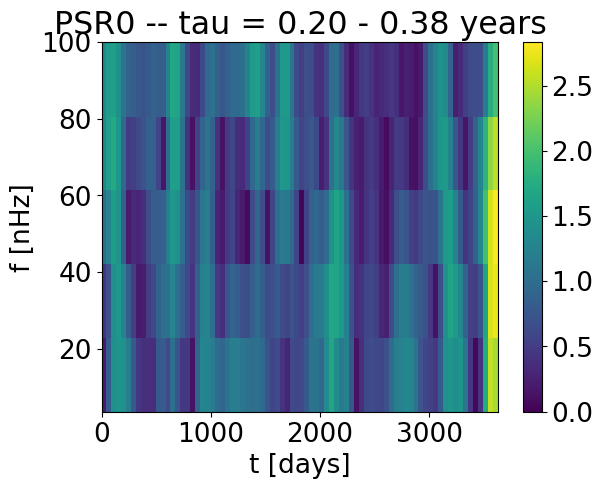

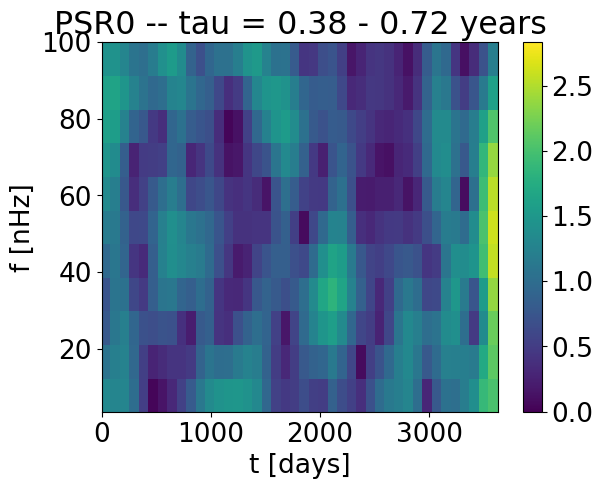

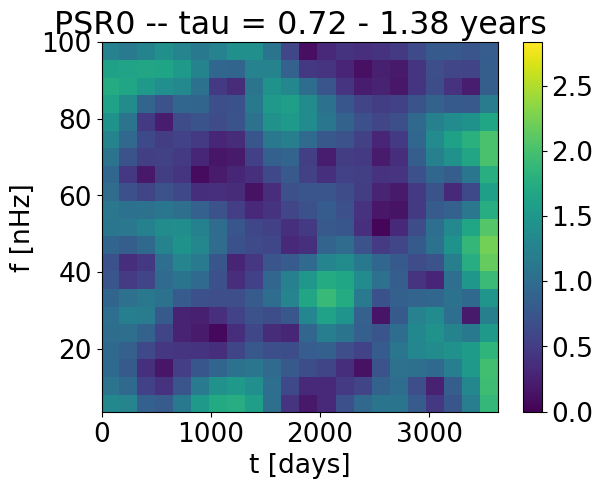

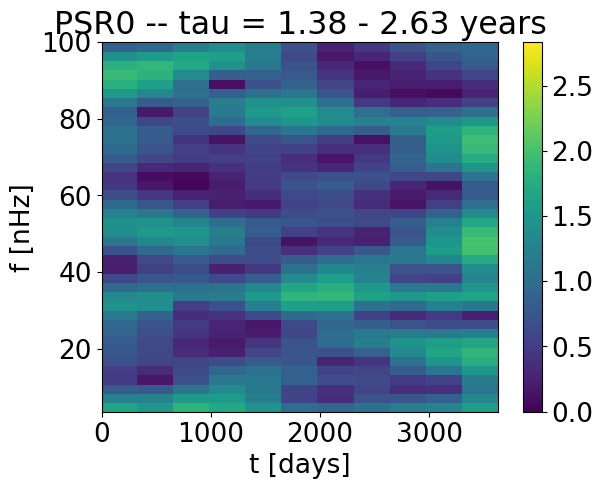

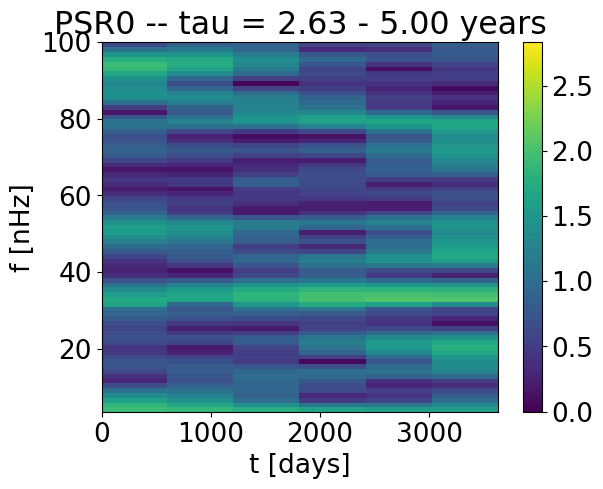

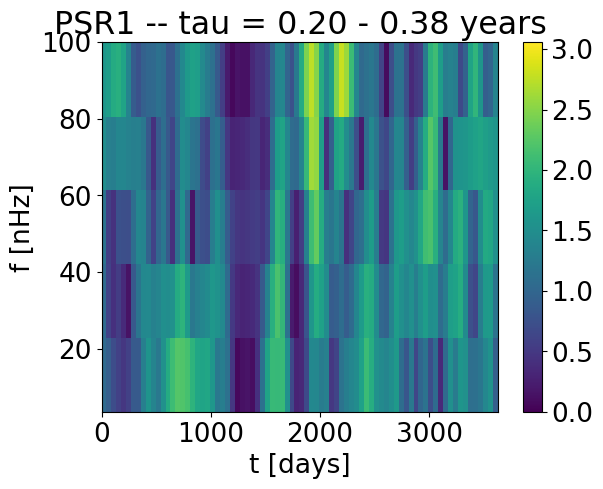

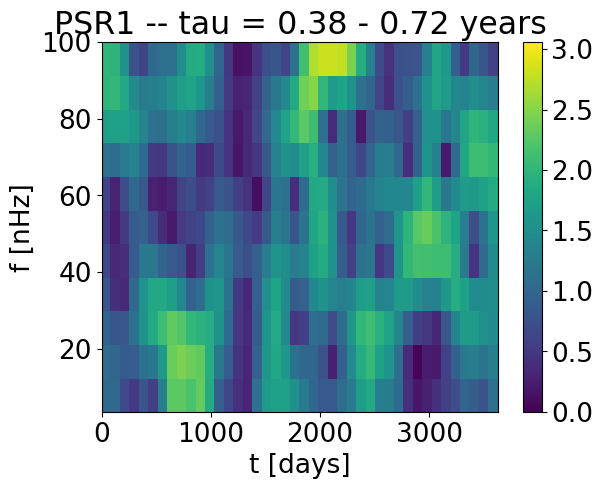

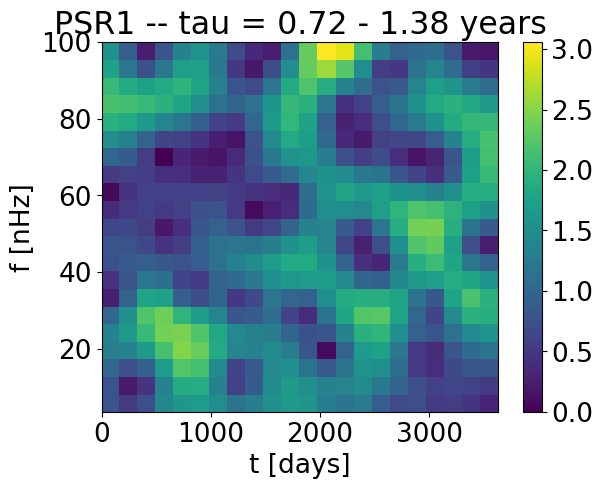

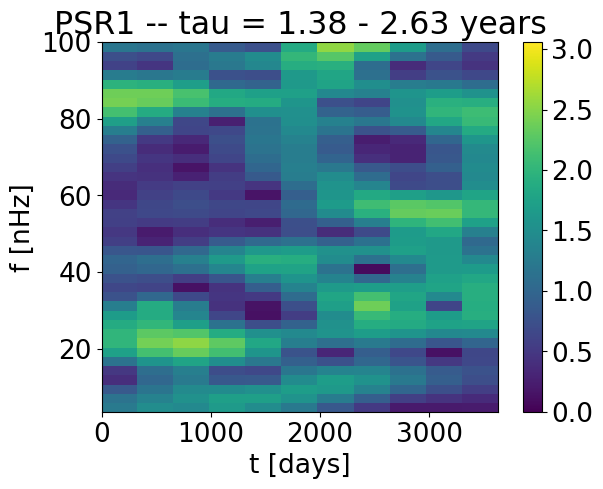

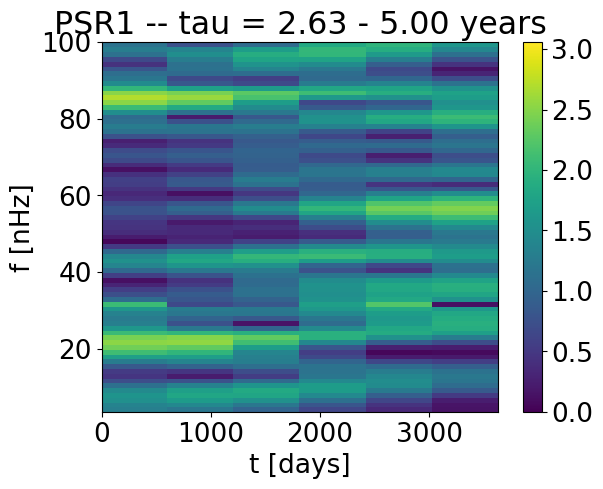

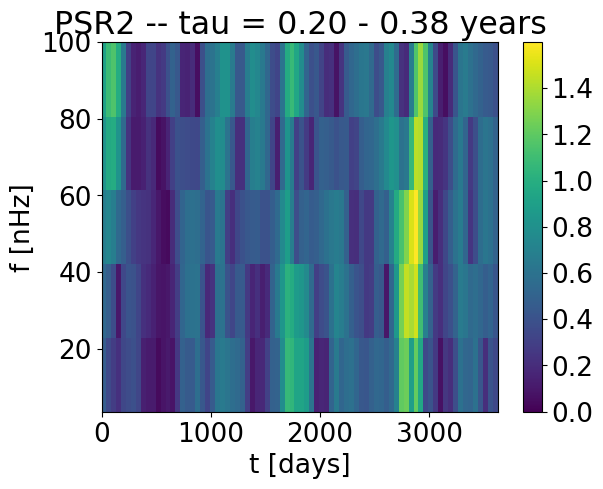

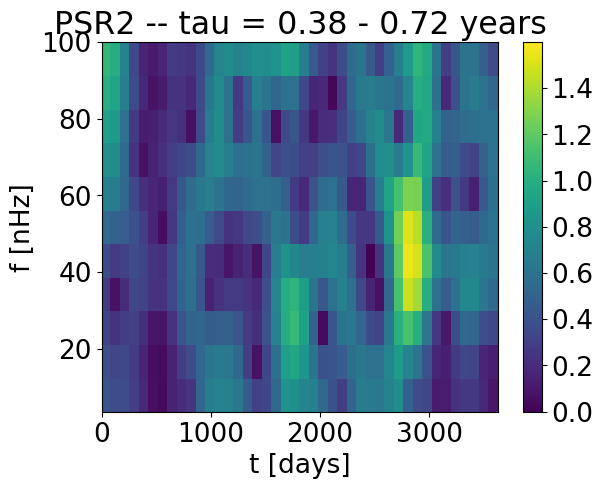

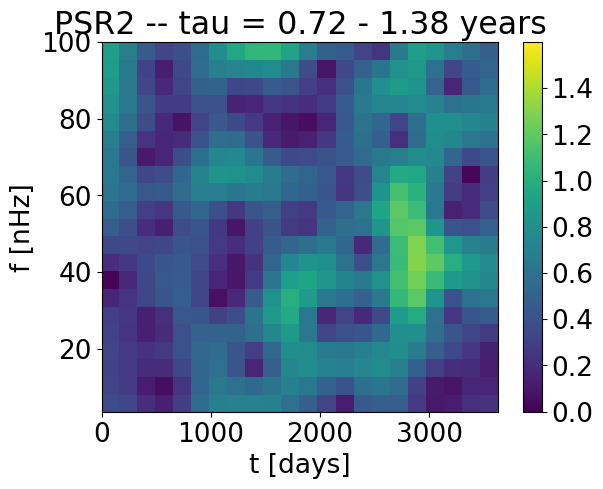

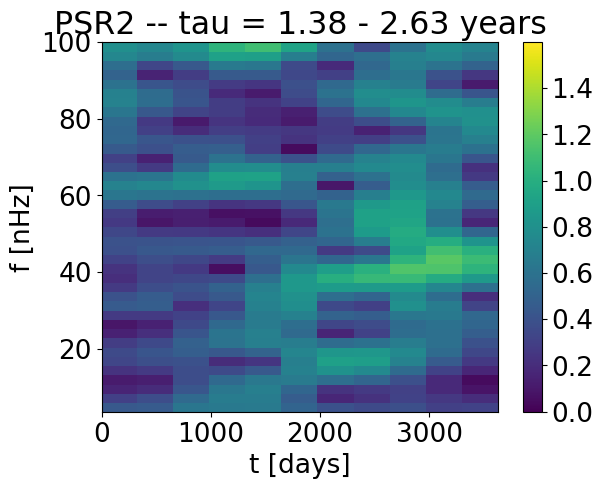

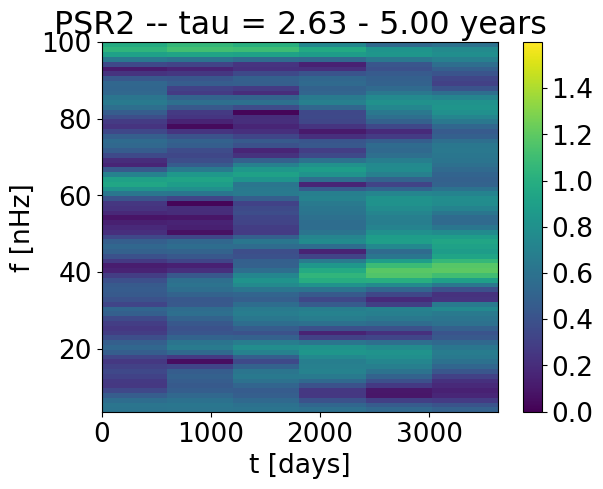

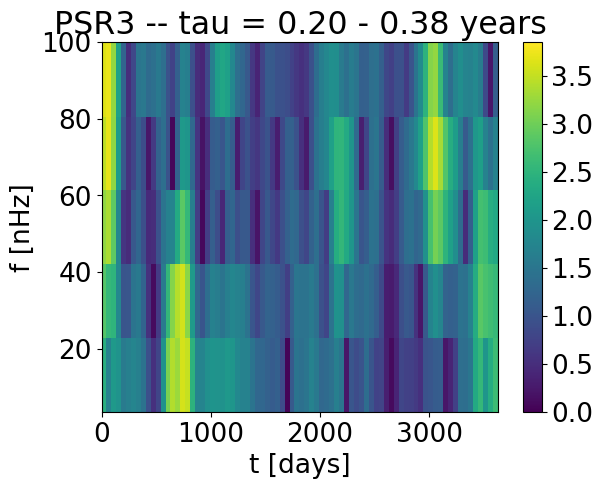

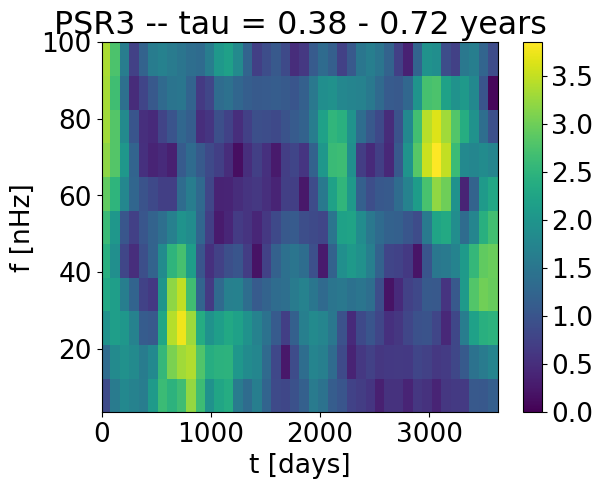

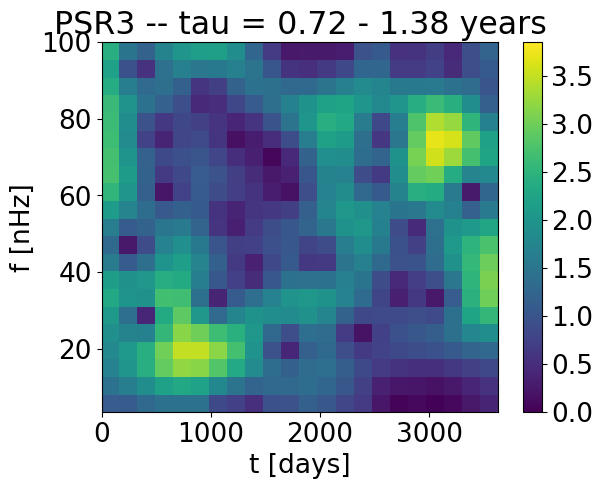

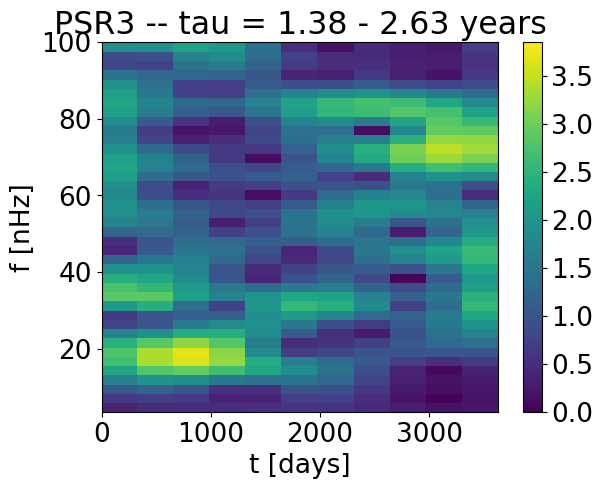

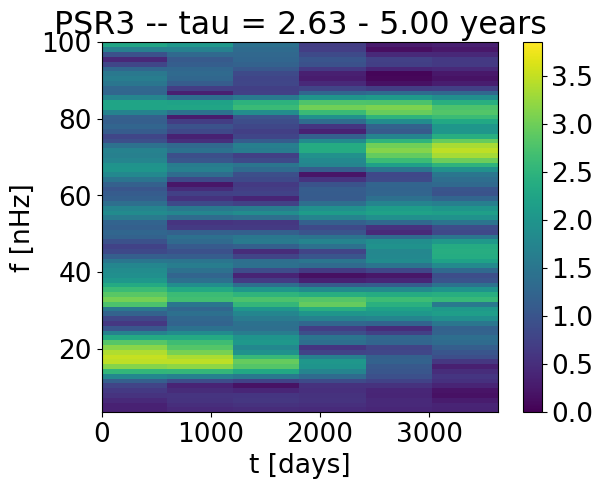

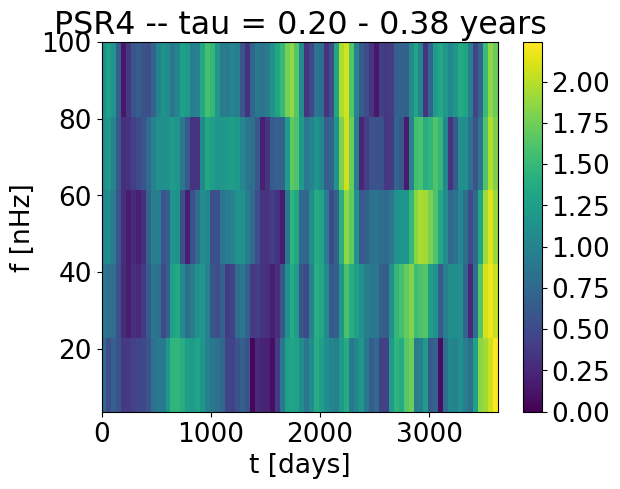

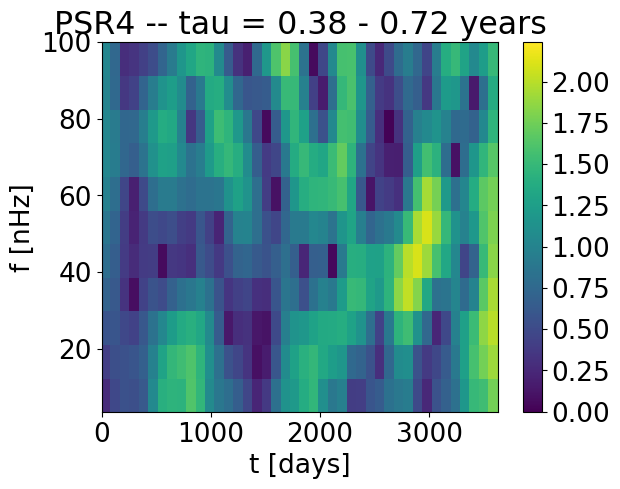

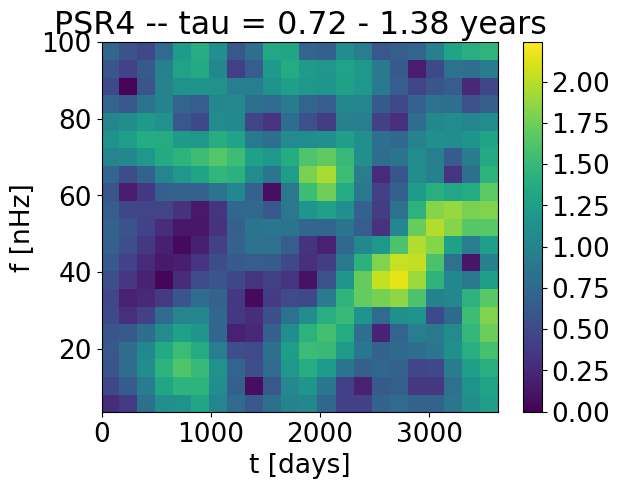

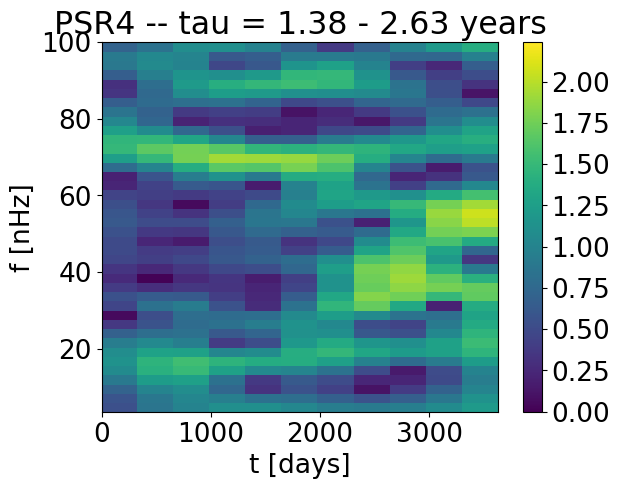

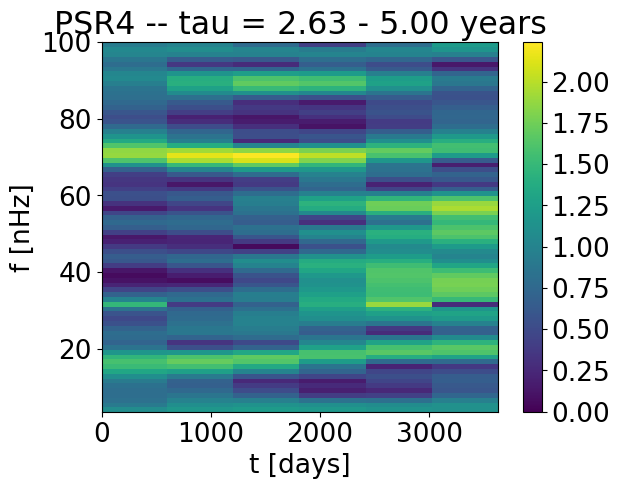

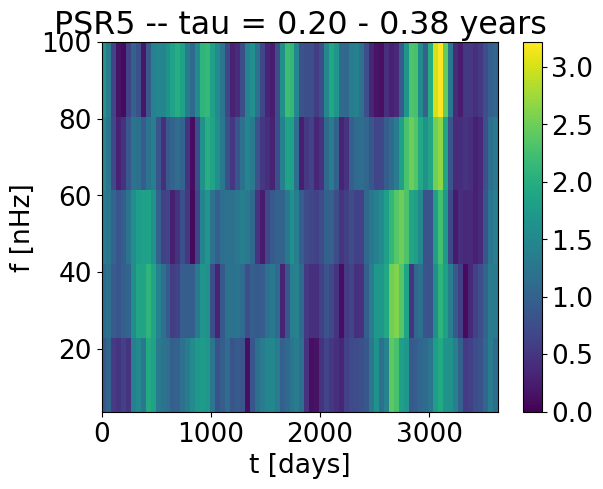

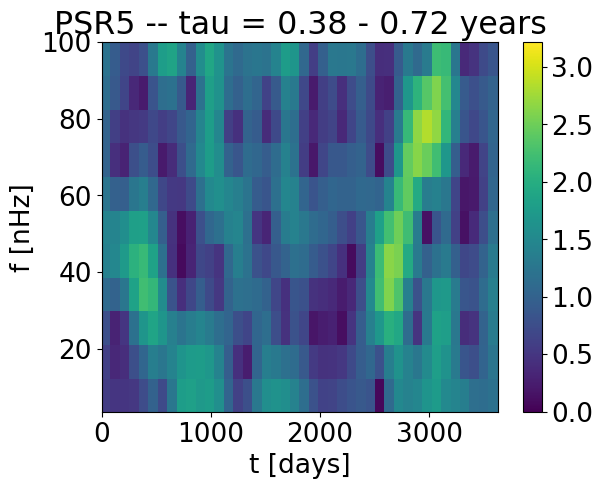

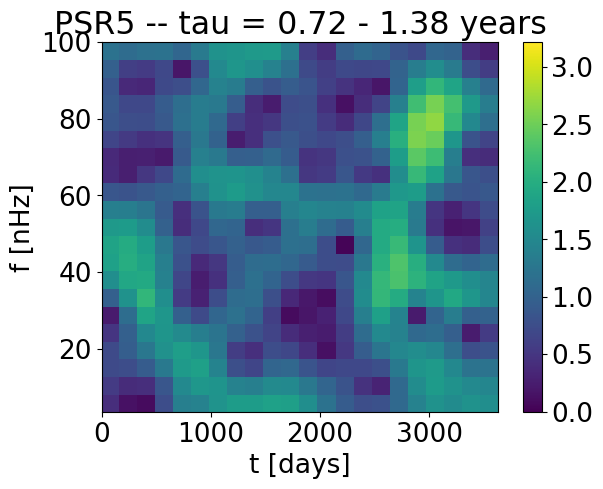

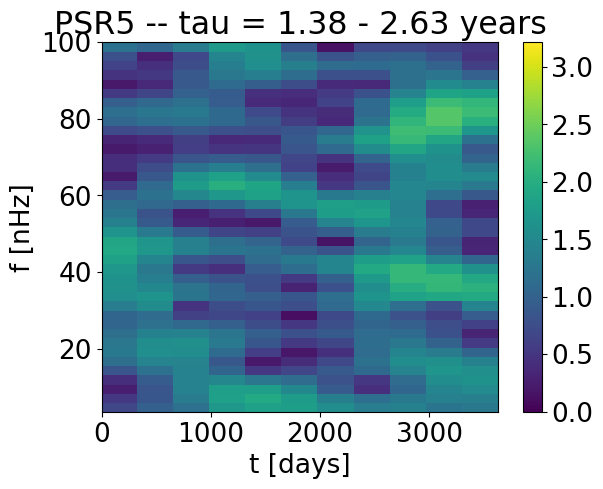

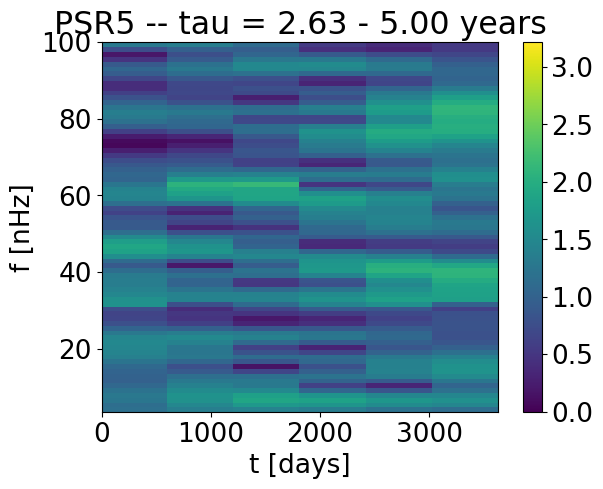

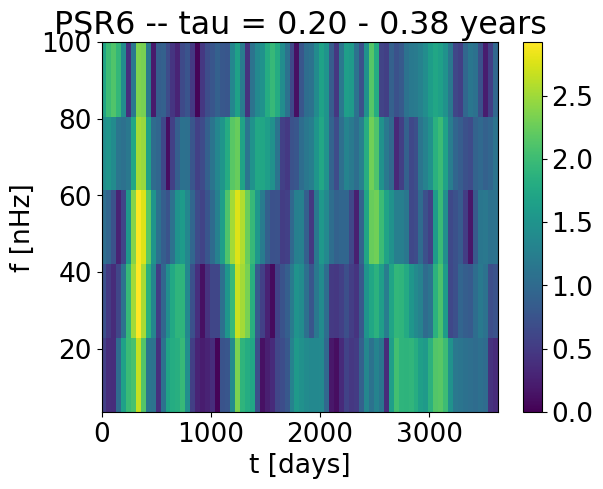

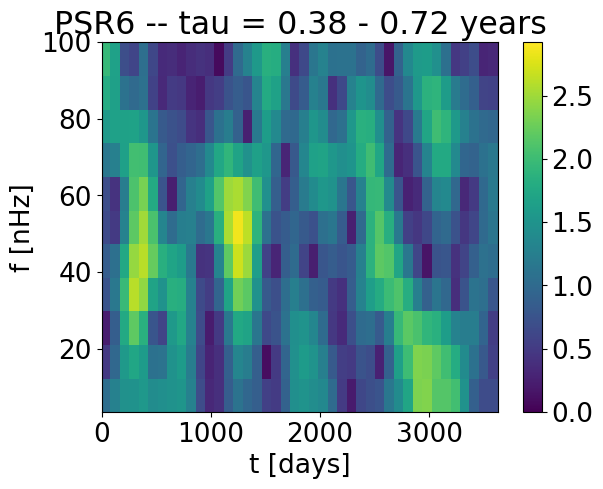

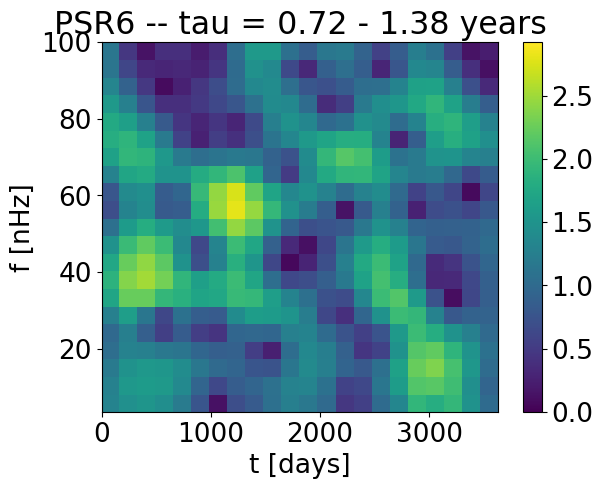

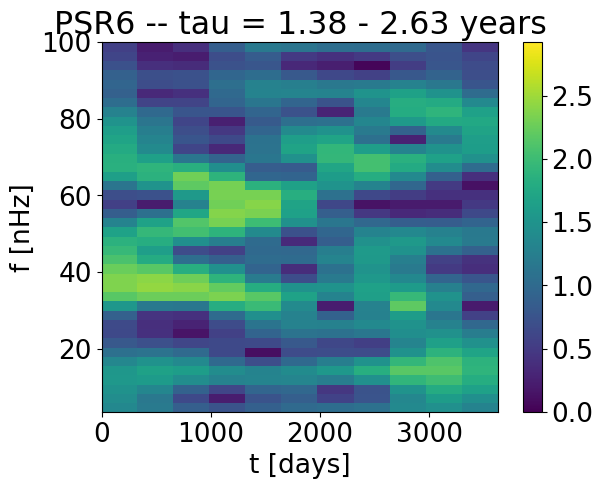

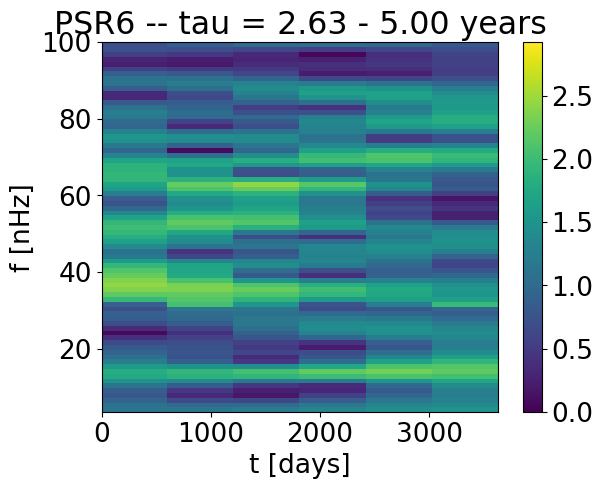

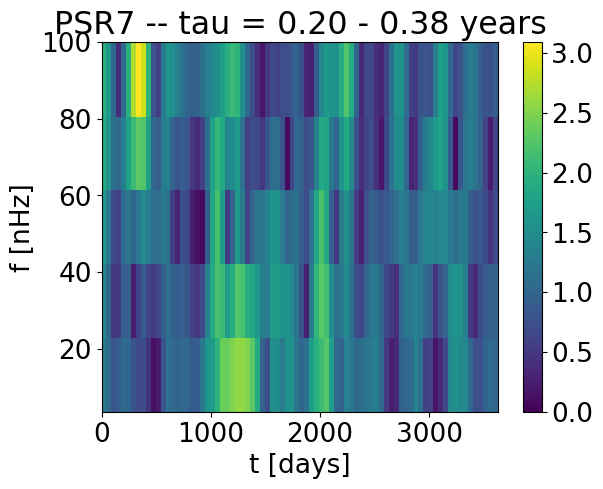

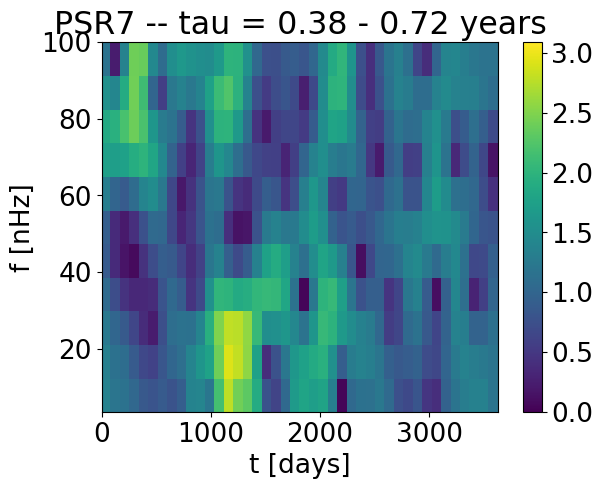

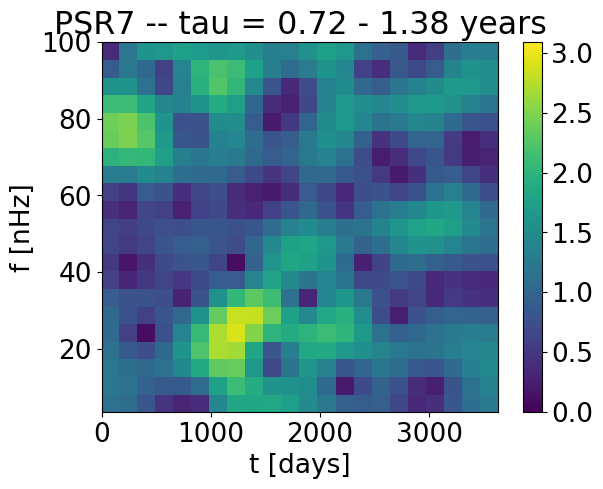

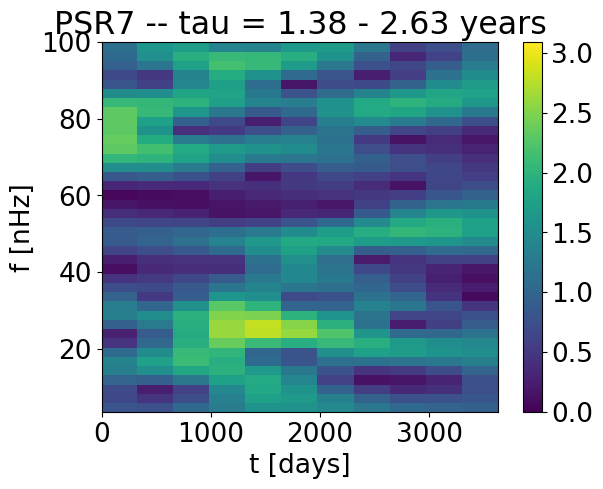

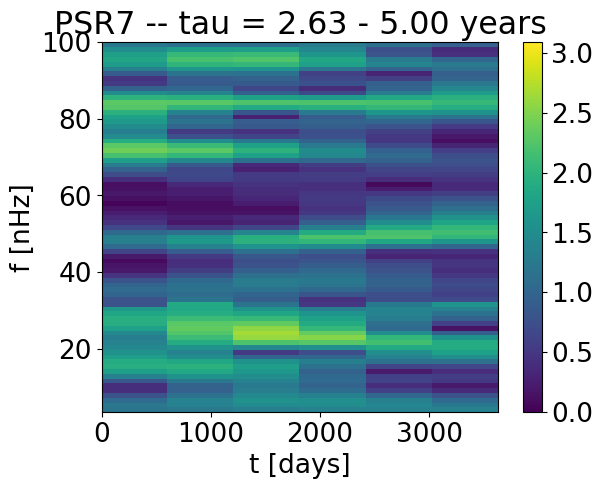

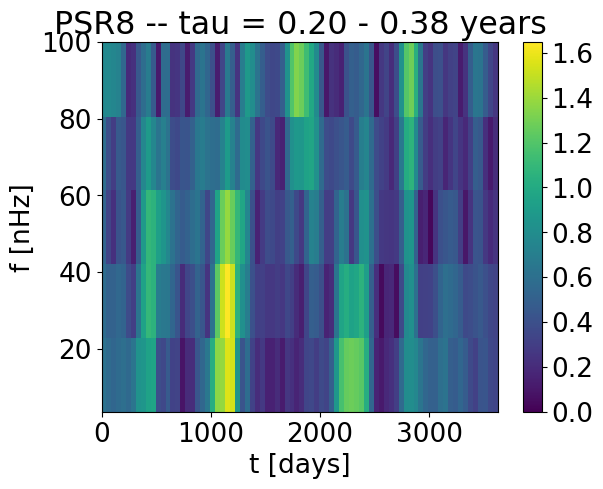

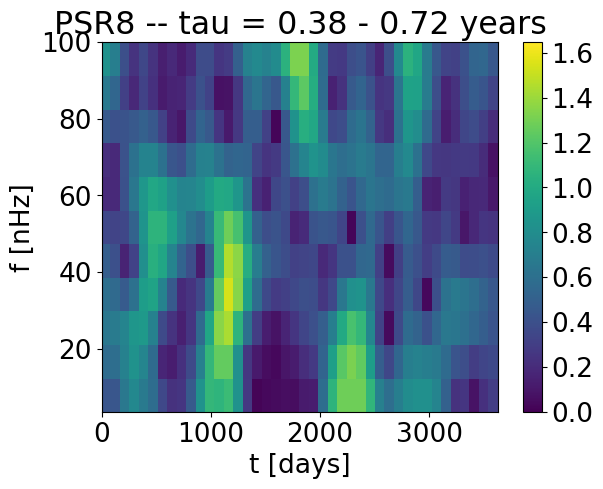

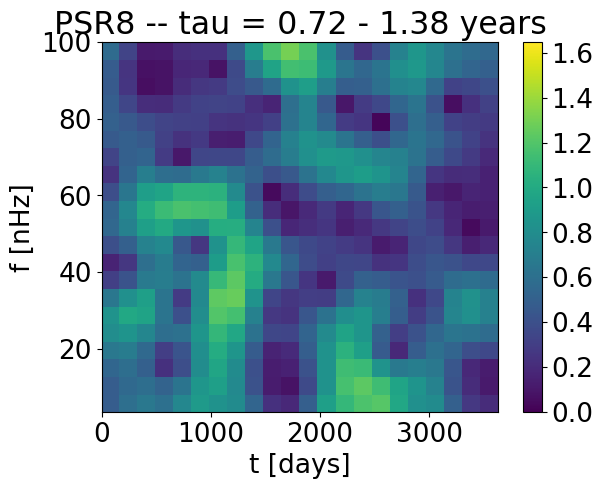

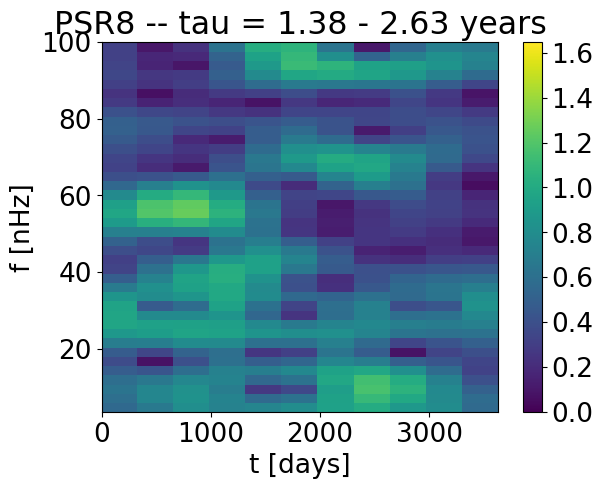

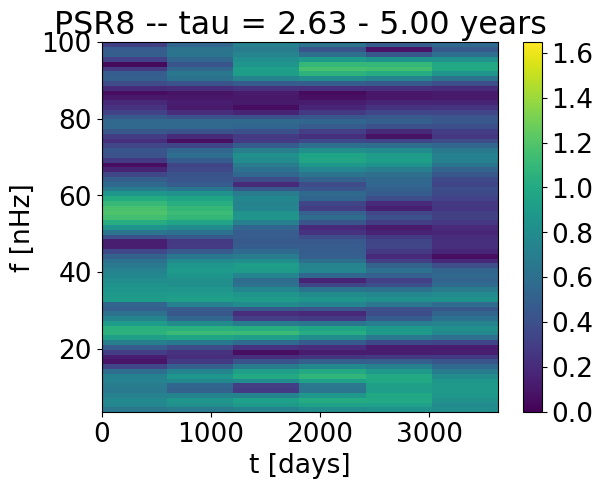

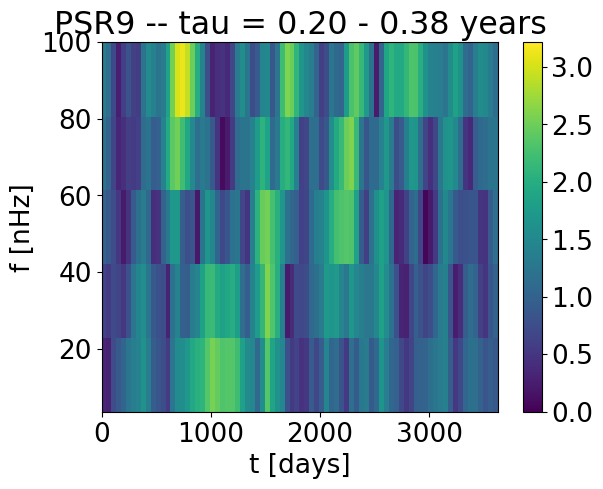

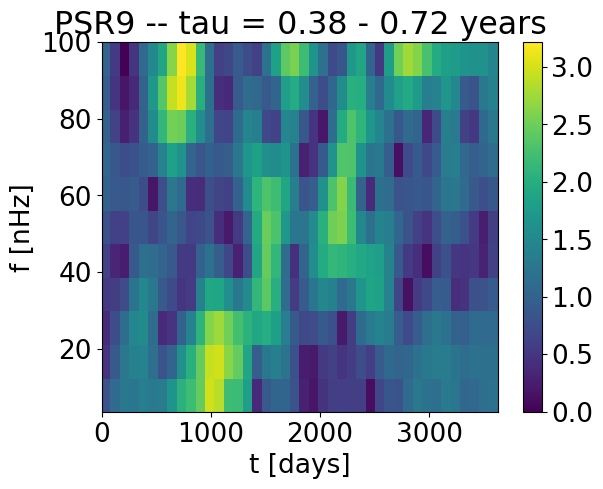

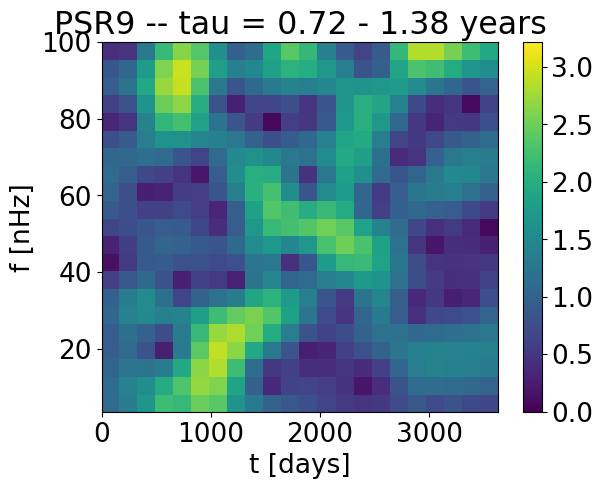

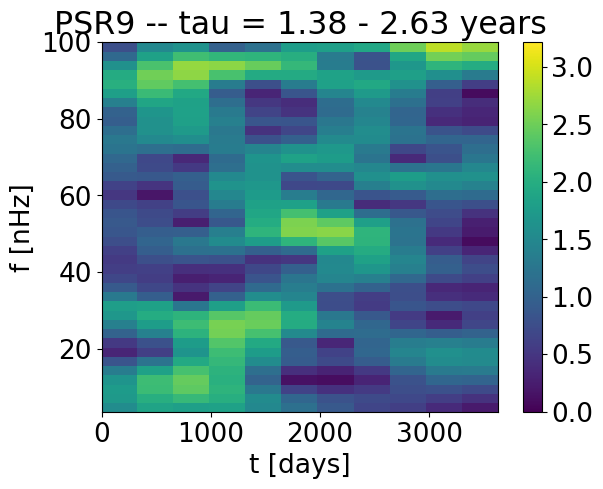

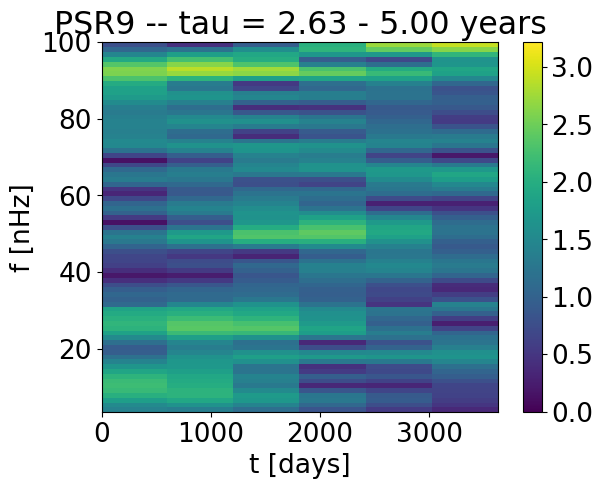

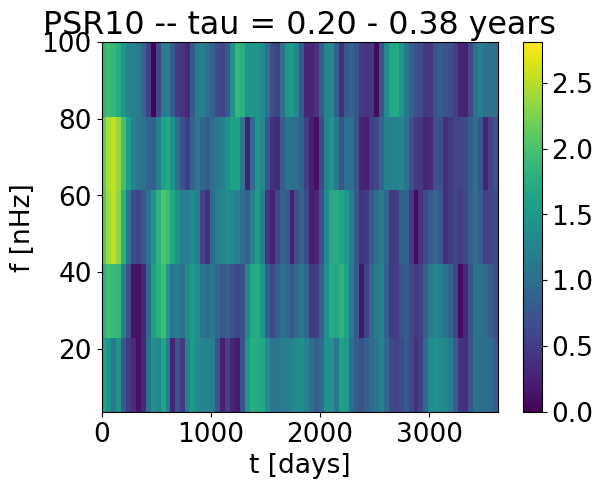

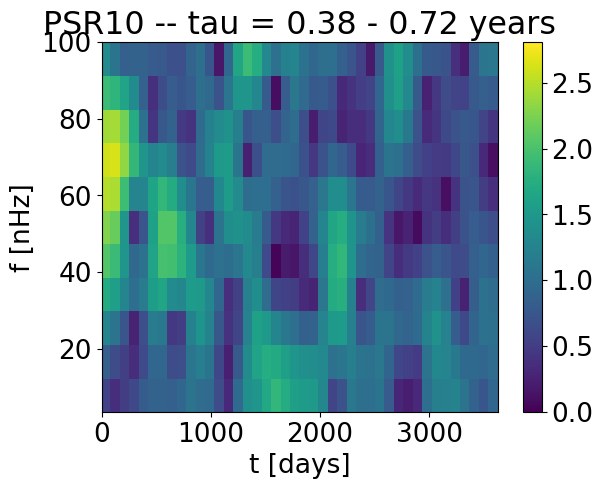

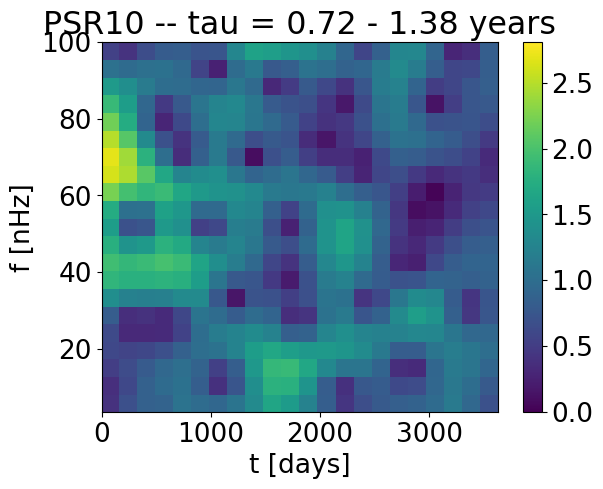

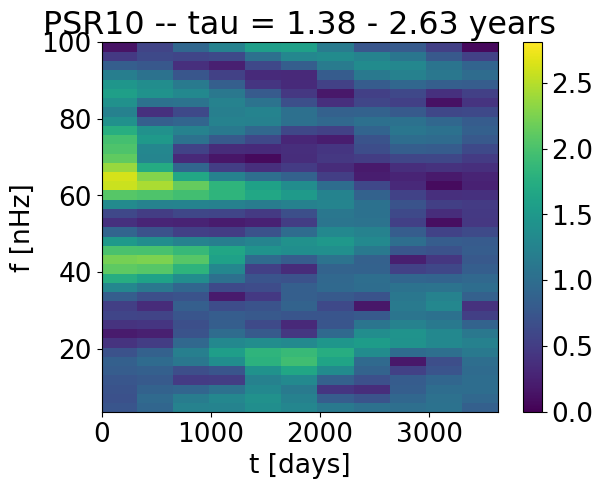

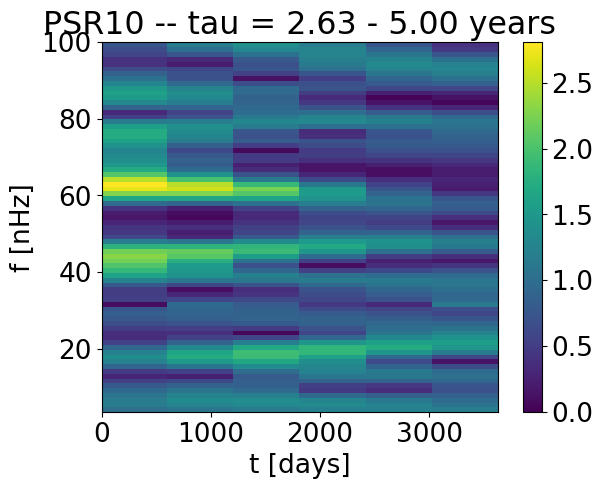

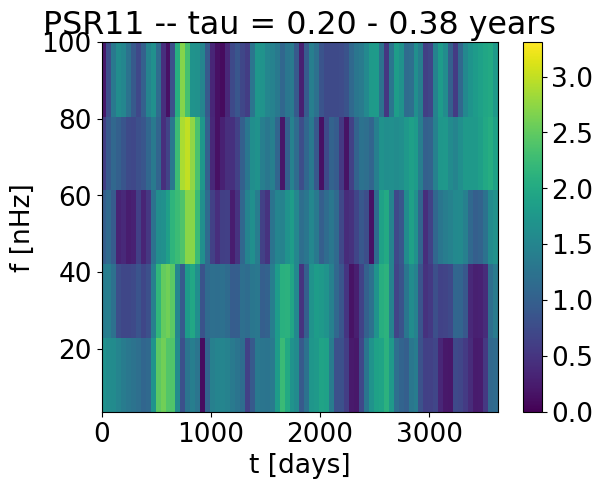

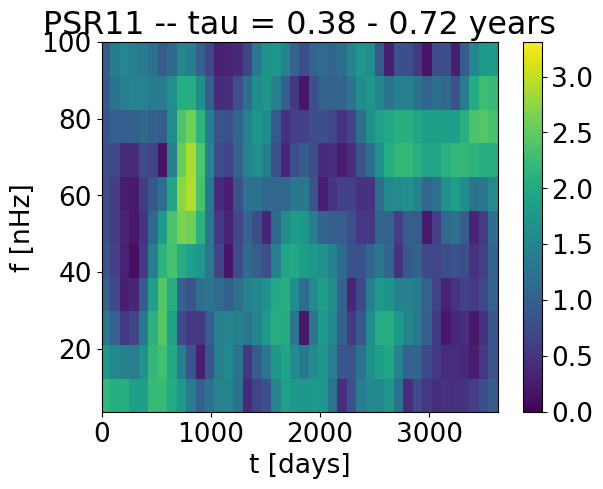

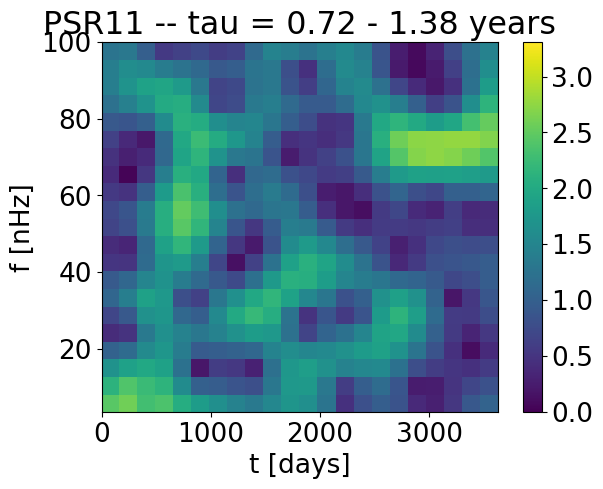

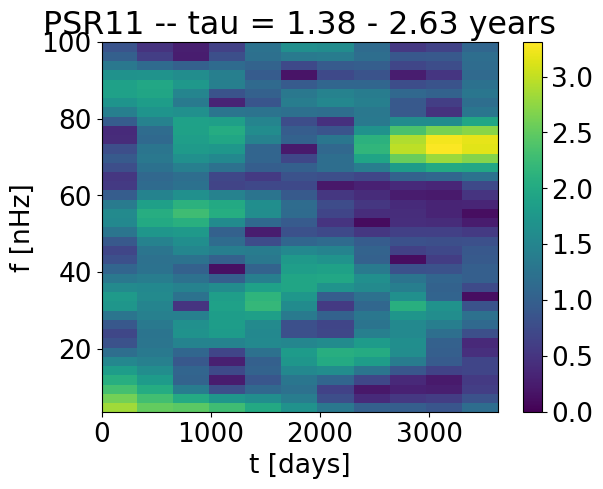

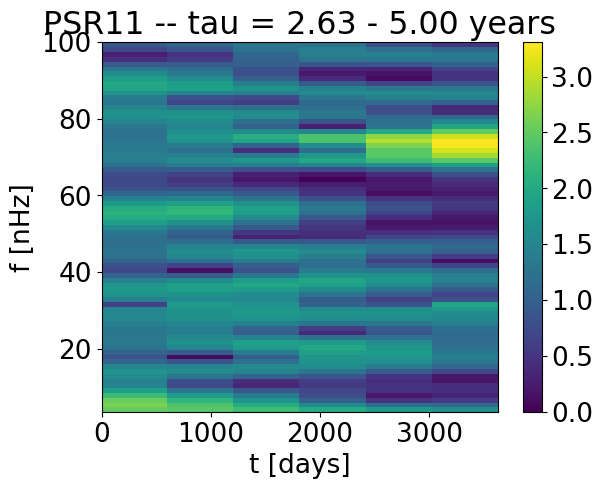

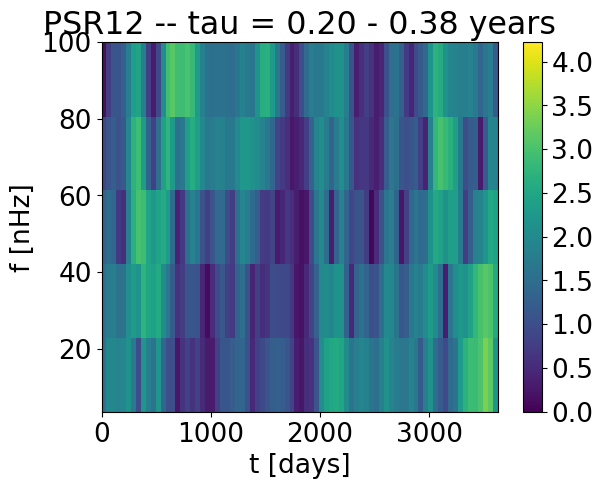

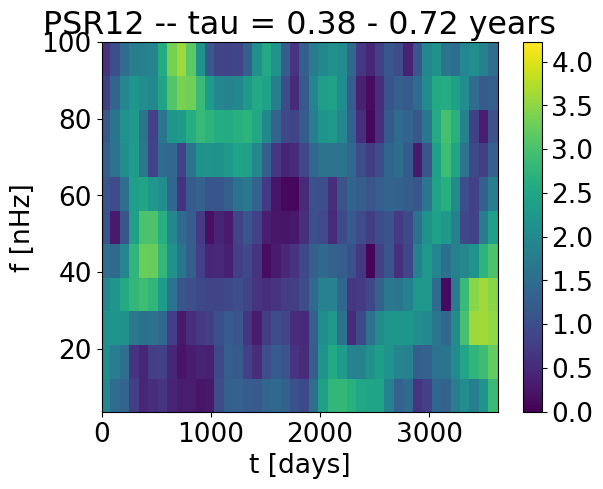

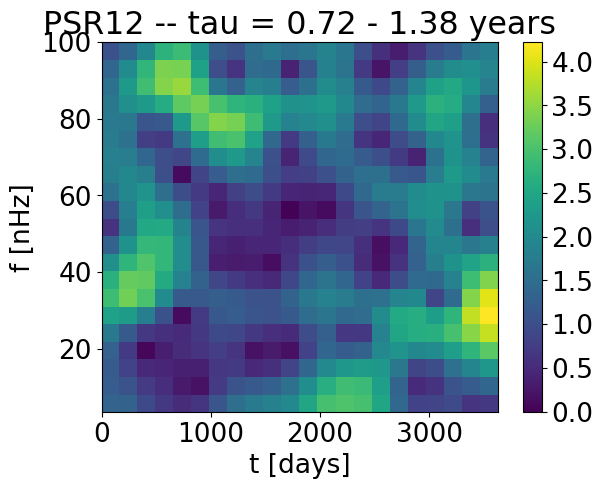

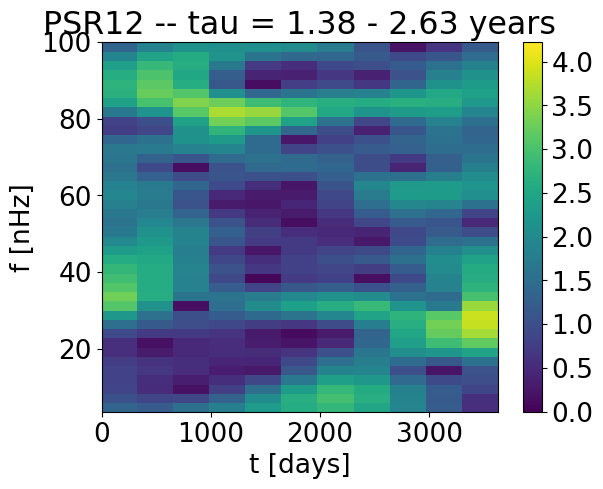

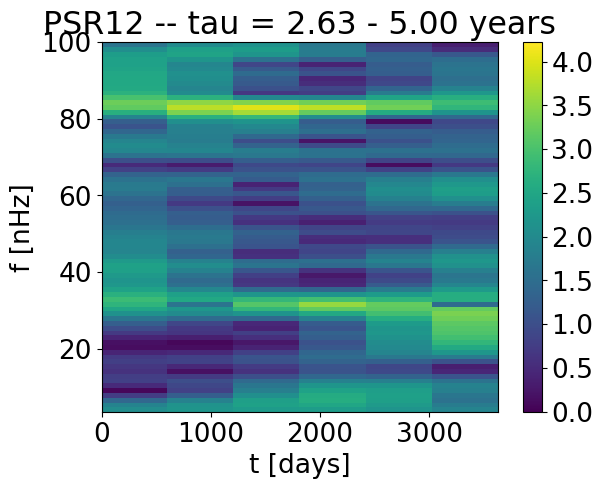

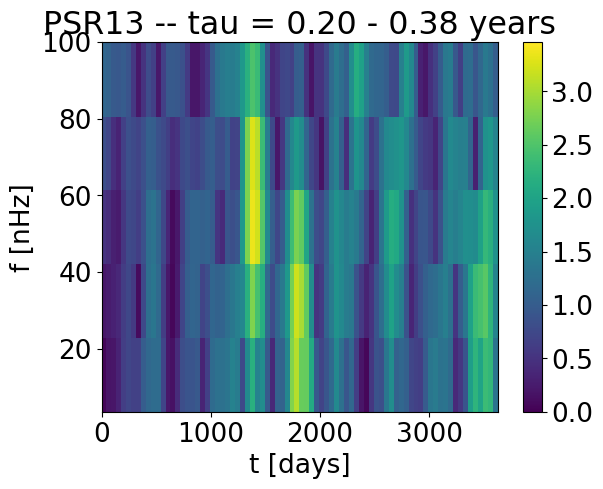

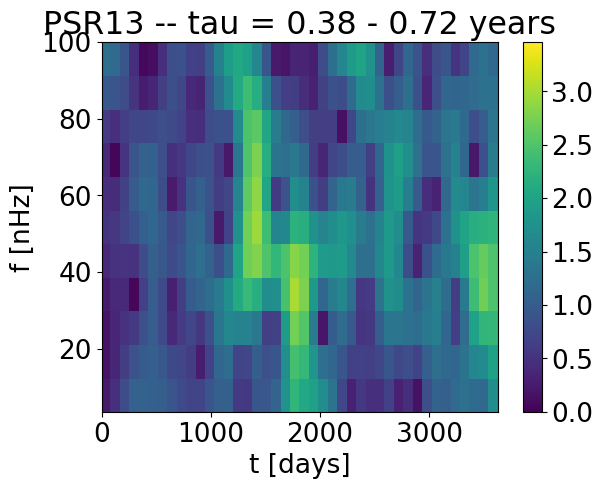

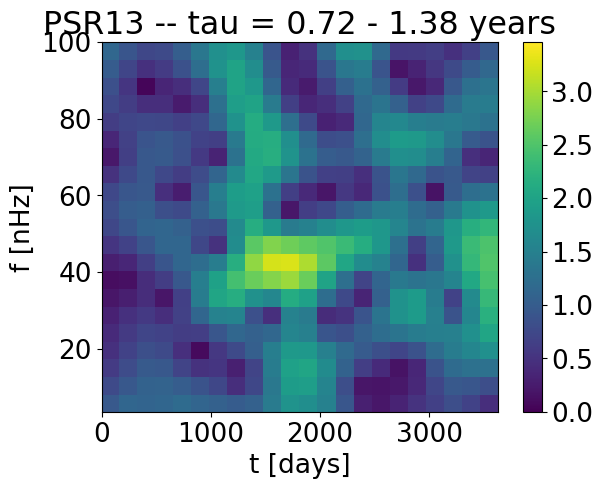

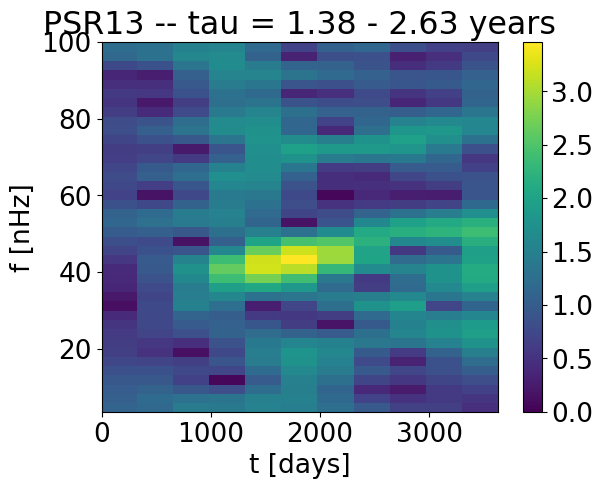

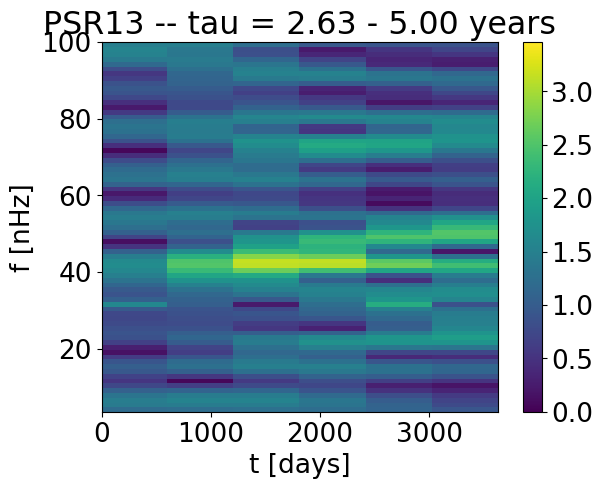

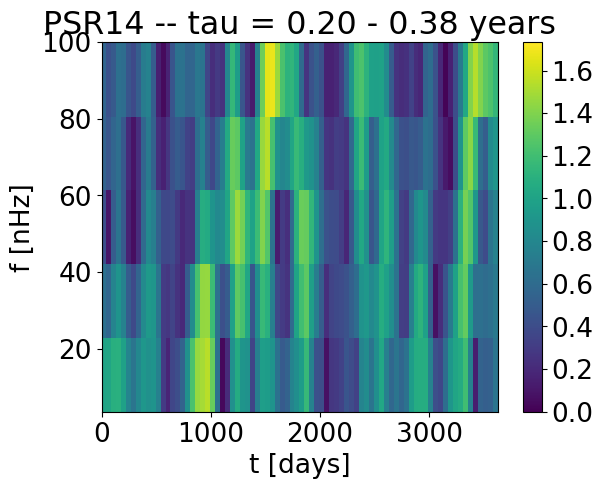

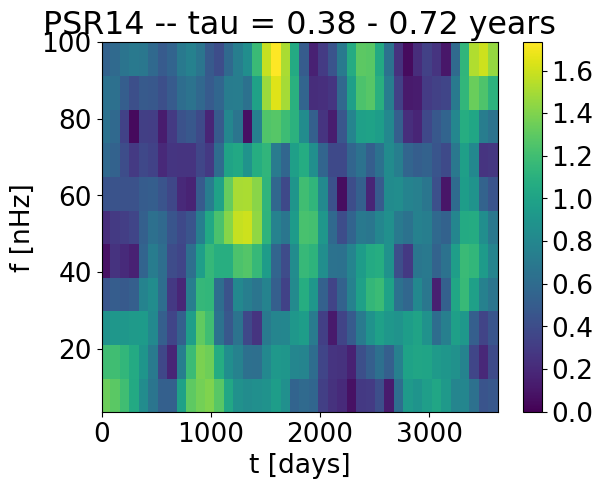

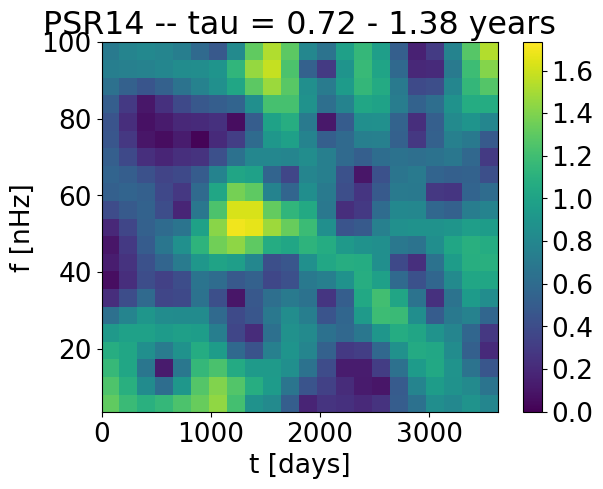

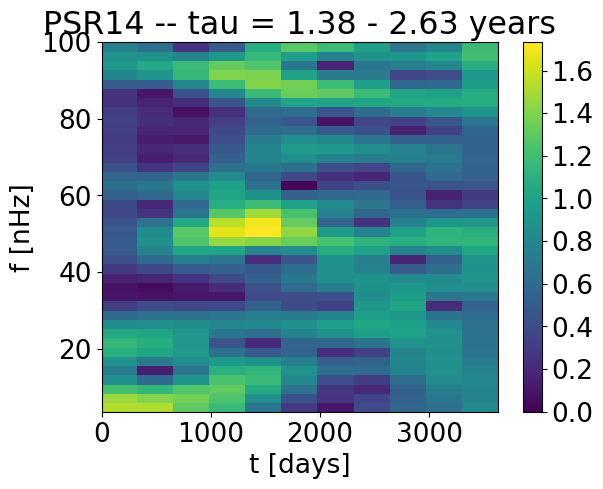

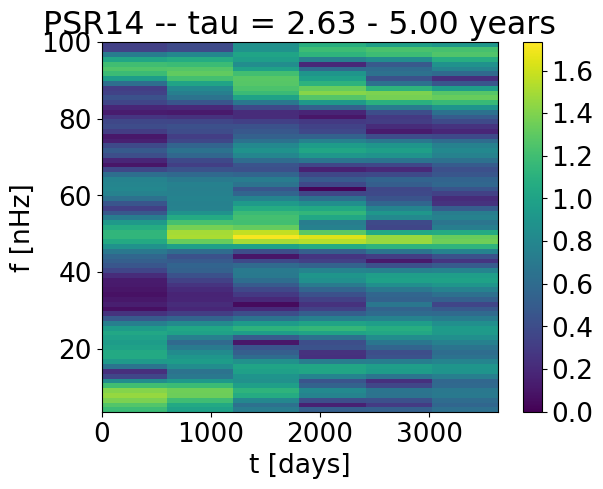

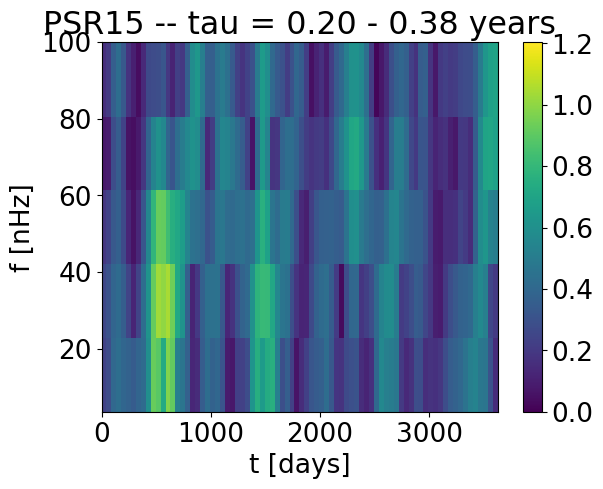

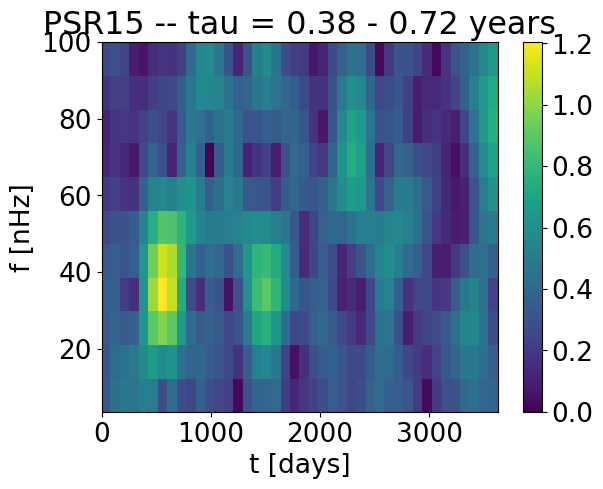

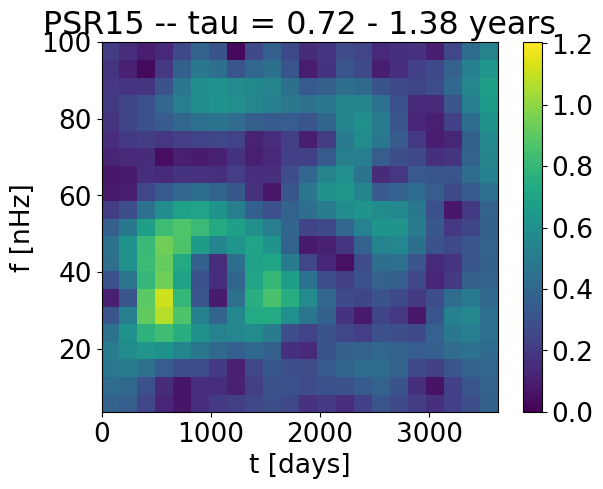

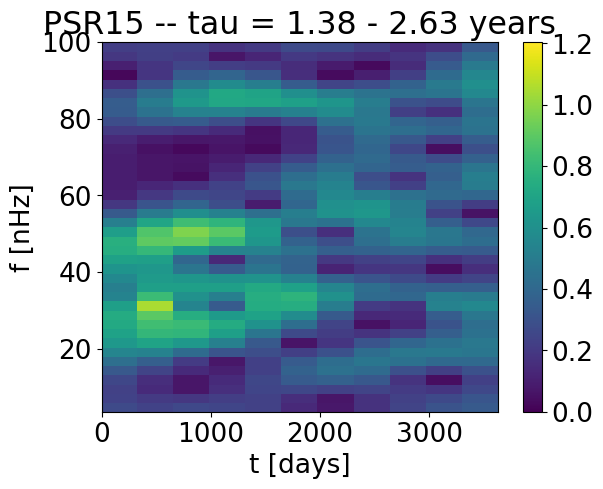

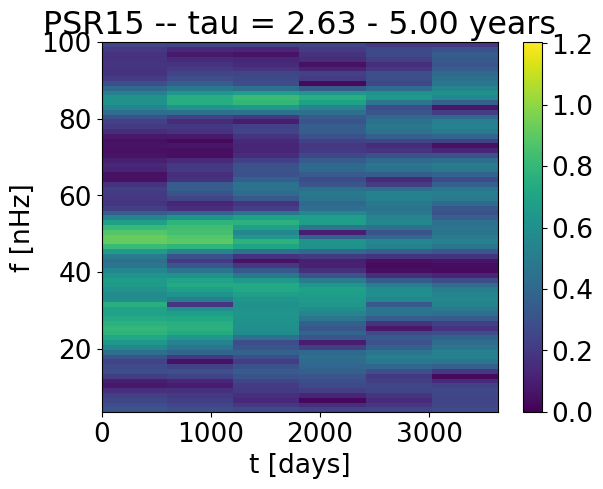

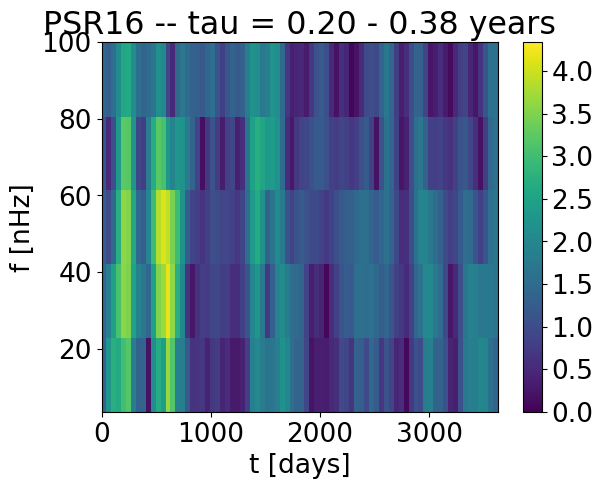

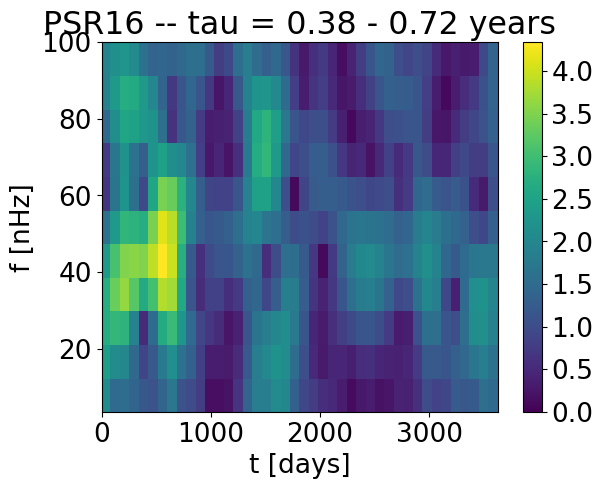

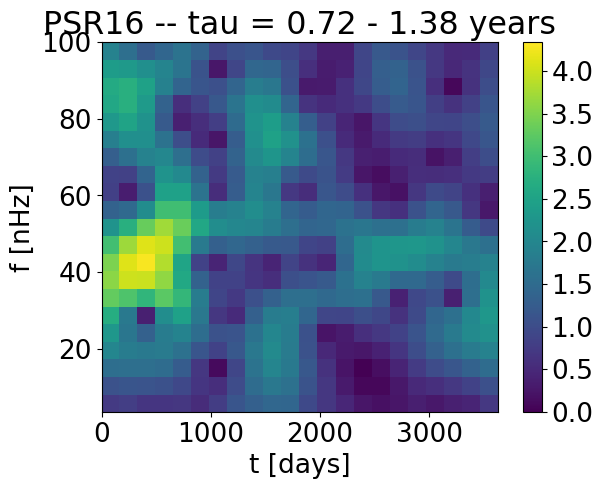

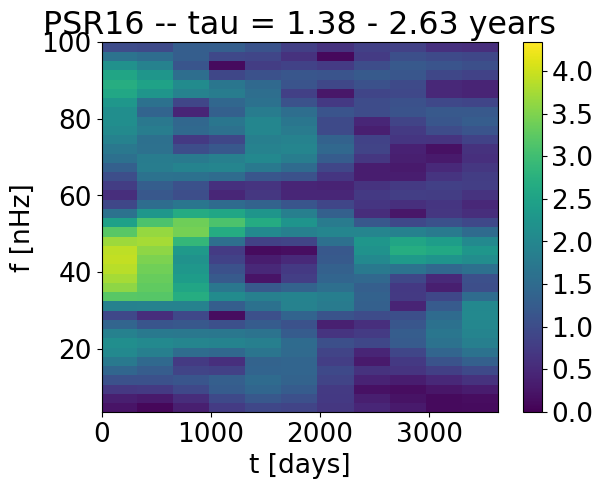

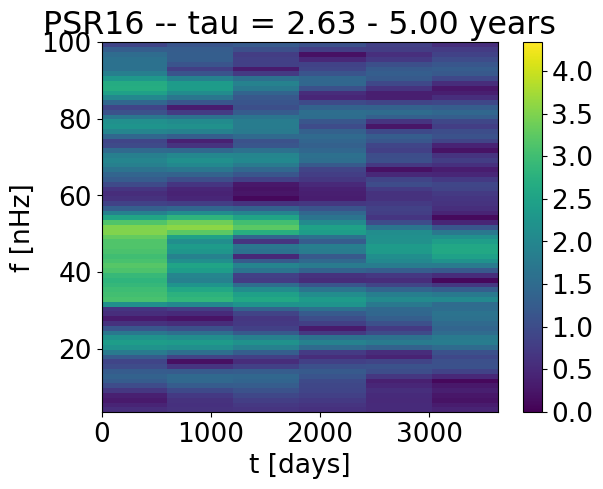

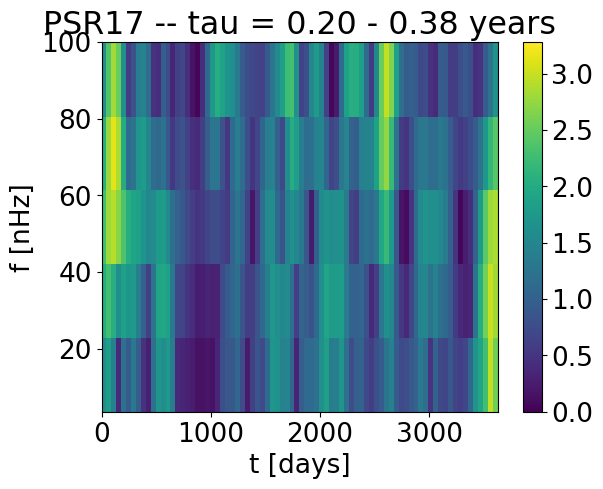

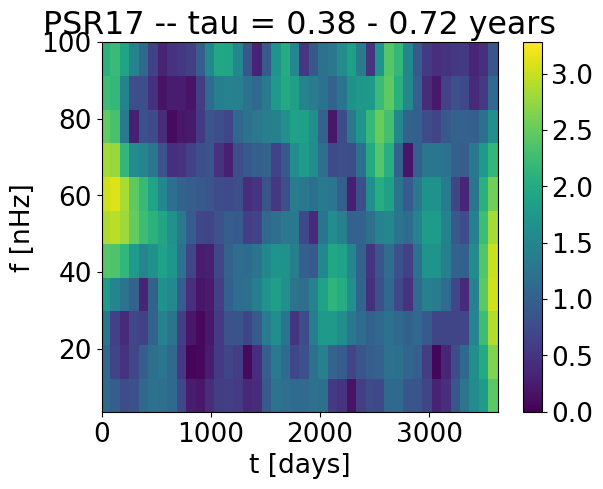

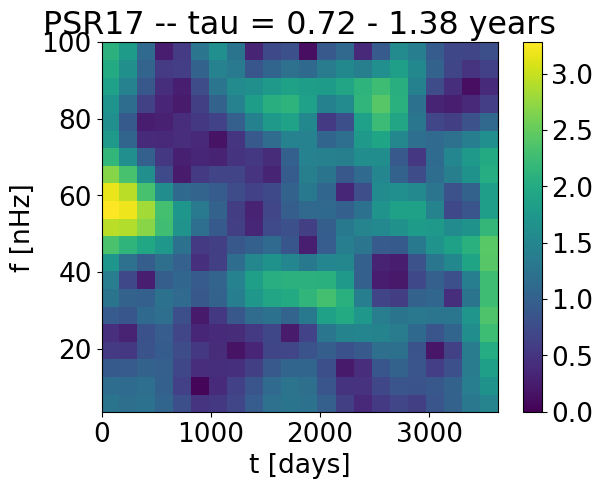

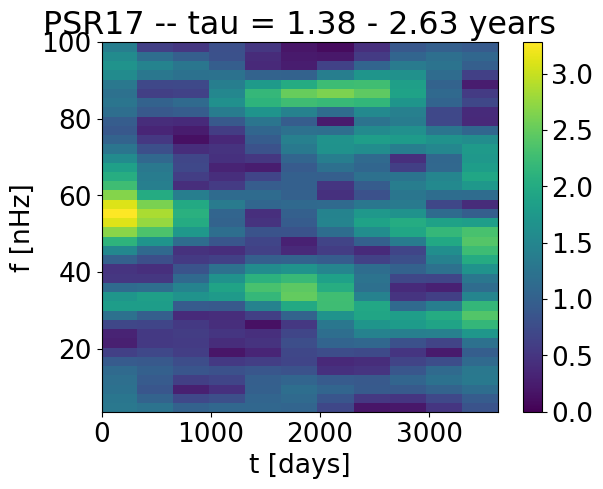

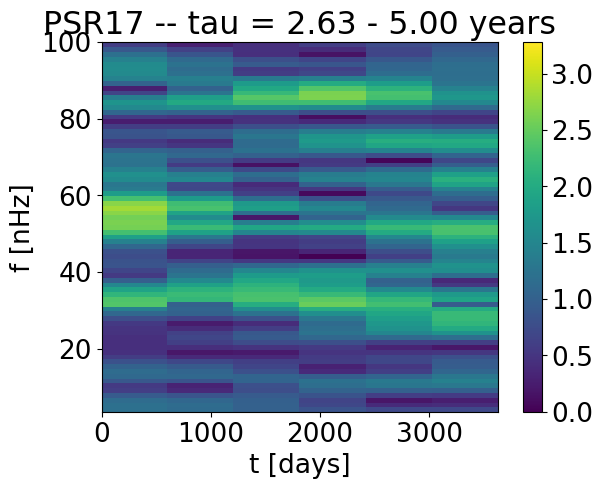

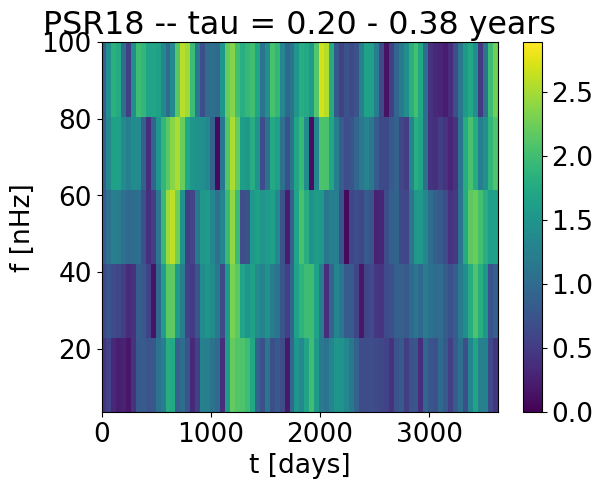

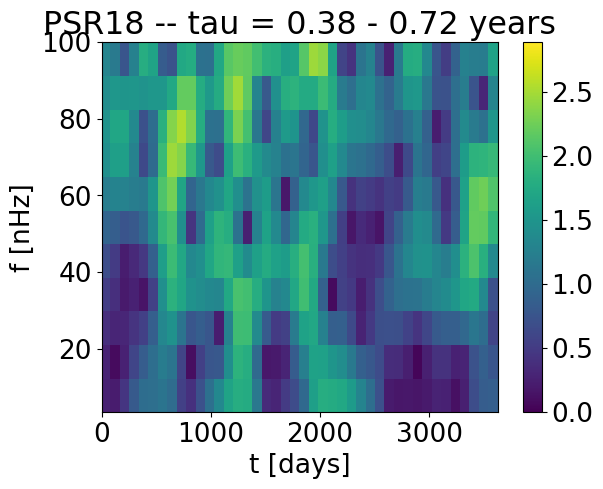

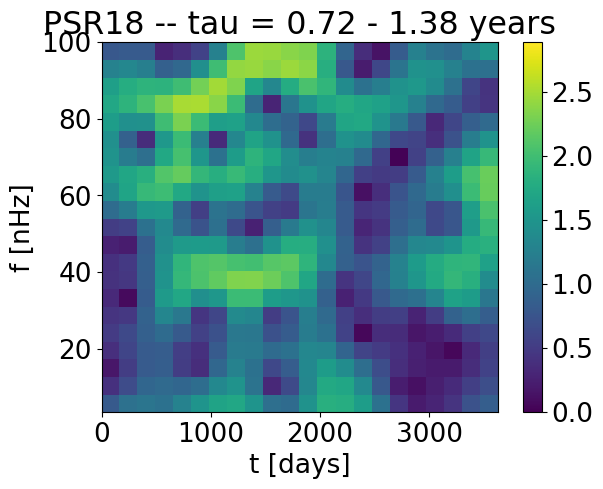

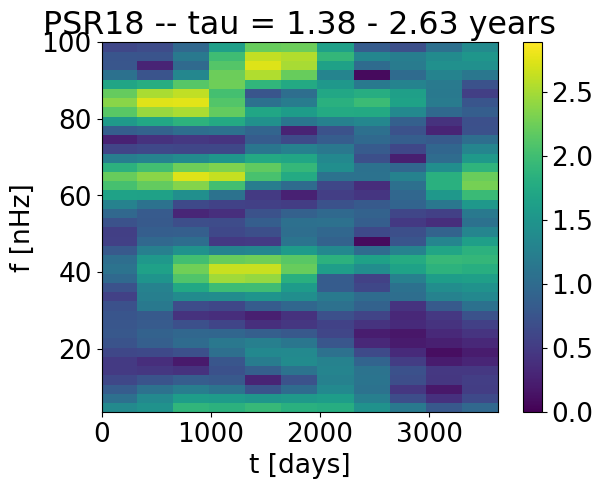

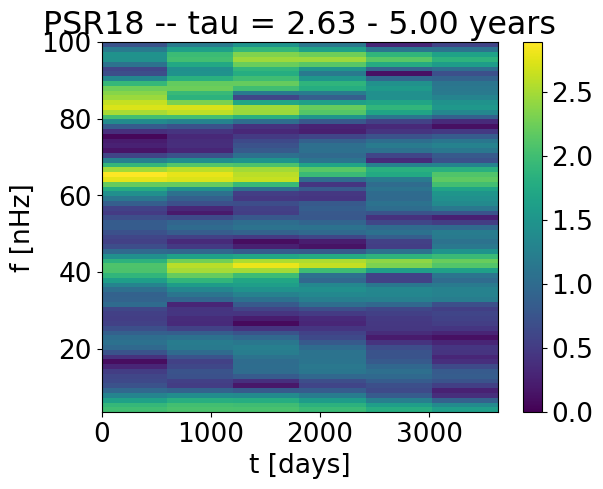

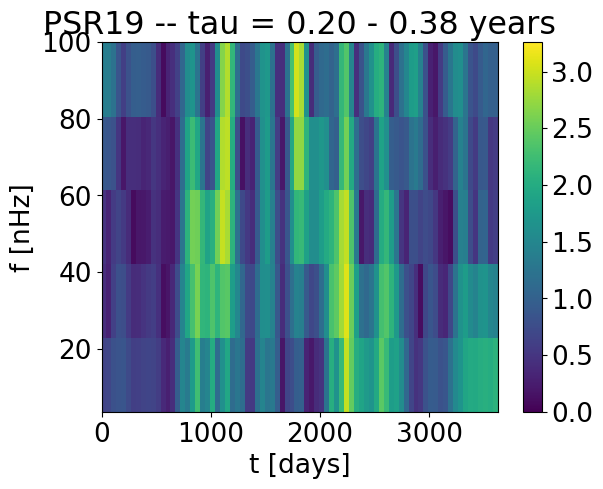

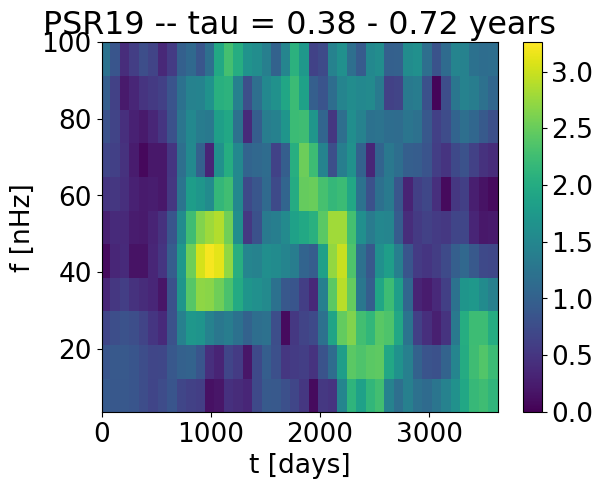

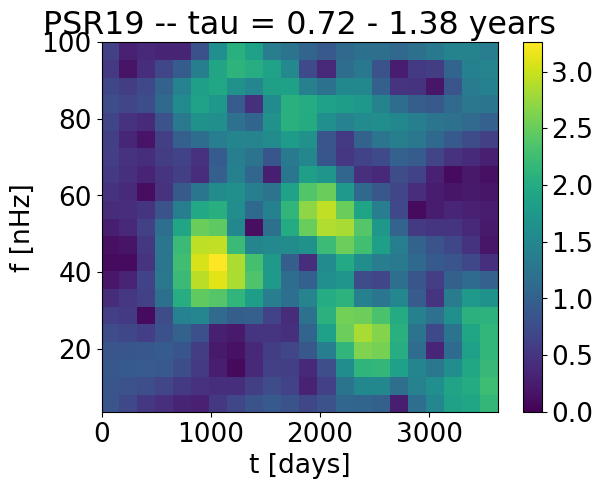

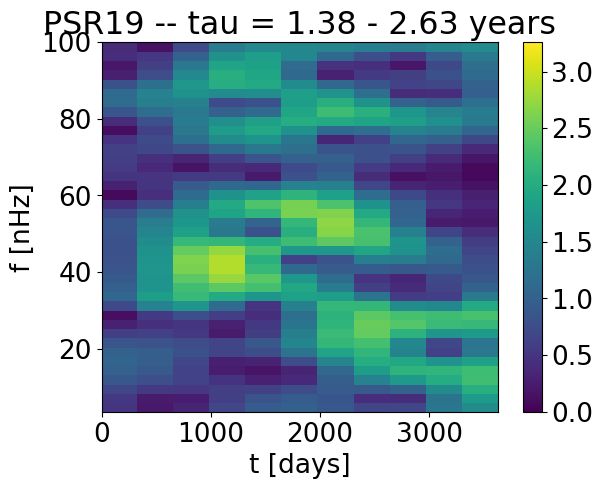

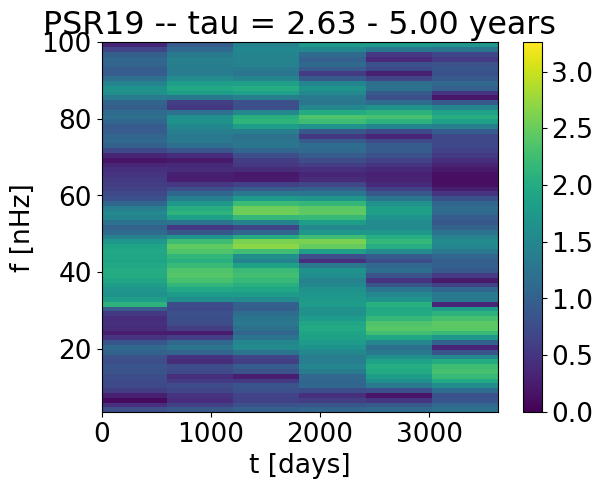

In [30]:
tau_edges = TS_all['tau_edges']
T0_list = TS_all['t0_edges']
F0_list = TS_all['f0_edges']

for i in range(len(psrs)):
    print(i)
    tau_scan = TS_all['tau_scan'+str(i)]
    scan_max = max([np.nanmax(x) for x in tau_scan])
    print(scan_max)
    for l in range(tau_edges.size-1):
        fig = plt.figure(l+i*(tau_edges.size-1))
        c = plt.gca().pcolormesh(T0_list[l]/24/3600, F0_list[l]/1e-9 ,np.sqrt(tau_scan[l]), vmax=np.sqrt(scan_max), vmin=0.0)
        plt.colorbar(c)
        plt.title("PSR{2:d} -- tau = {0:.2f} - {1:.2f} years".format(tau_edges[l], tau_edges[l+1], i))
        plt.xlabel("t [days]")
        plt.ylabel("f [nHz]")

# Stitching together individual glitch tau scans and saving combined tau scan

In [31]:
TS_dict = {} #holds the wavelet tau scans (combination of all pulsars)

for i in range(len(psrs)):
    glitch_tau_scan_data = np.copy(TS_all['tau_scan{}'.format(i)])
    
    #Only populate tau edges, f0, t0 once. Same for all pulsars
    print('Pulsar {}'.format(i))
    if i==0:
        TS_dict['tau_edges'] = TS_all['tau_edges']
        TS_dict['f0_edges'] = TS_all['f0_edges']
        TS_dict['t0_edges'] = TS_all['t0_edges']
        TS_dict['tau_scan'] = glitch_tau_scan_data
    
    #Otherwise, stitch together tau scans for each pulsar to get wavelet tau scans
    else:
        for j in range(len(TS_dict['tau_scan'])):
            ts = glitch_tau_scan_data
            TS_dict['tau_scan'][j] += np.where(np.isnan(ts[j]), 0.0, ts[j])

Pulsar 0
Pulsar 1
Pulsar 2
Pulsar 3
Pulsar 4
Pulsar 5
Pulsar 6
Pulsar 7
Pulsar 8
Pulsar 9
Pulsar 10
Pulsar 11
Pulsar 12
Pulsar 13
Pulsar 14
Pulsar 15
Pulsar 16
Pulsar 17
Pulsar 18
Pulsar 19


/home/mitch/miniconda3/envs/QuickBurst/lib/python3.9/site-packages/numpy/lib/function_base.py:935: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, order=order, subok=subok, copy=True)


## Saving stitched together tau scans (i.e. Wavelet tau scans)

In [33]:
with open("../20_simple_psrs_data/wavelet_tau_scan.pkl", 'wb') as f:
    pickle.dump(TS_dict, f)

In [7]:
# with open("home/user/filepath.../wavelet_tau_scan.pkl", 'rb') as f:
#     TS_dict = pickle.load(f)

## Plotting wavelet tau scan

61.659016532477835


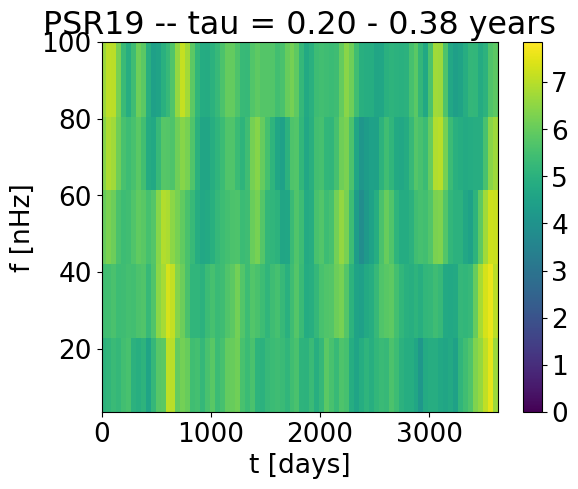

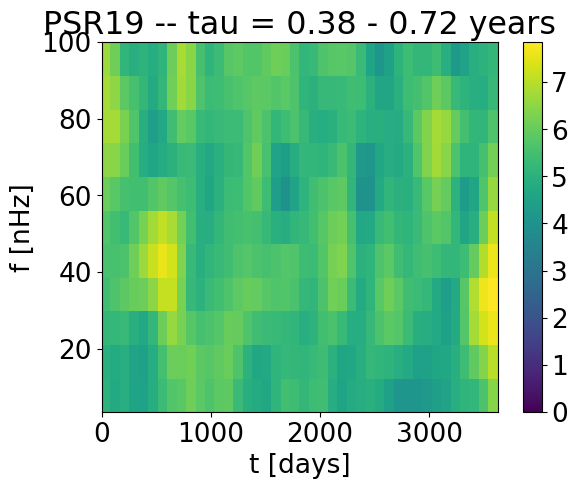

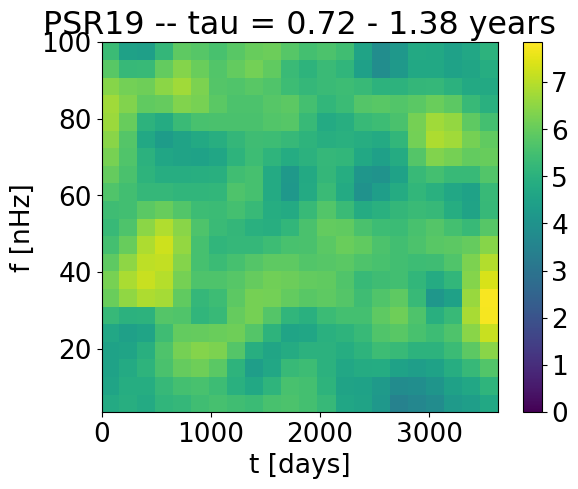

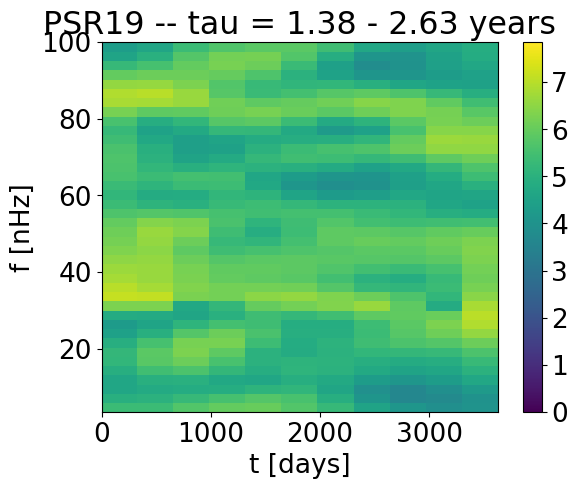

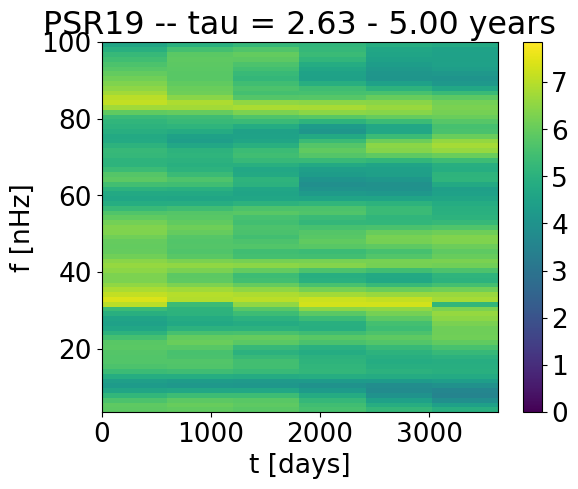

In [35]:
tau_edges = TS_dict['tau_edges']
T0_list = TS_dict['t0_edges']
F0_list = TS_dict['f0_edges']
tau_scan = TS_dict['tau_scan']

scan_max = max([np.nanmax(x) for x in tau_scan])
print(scan_max)

for l in range(tau_edges.size-1):
    fig = plt.figure(l+i*(tau_edges.size-1))
    c = plt.gca().pcolormesh(T0_list[l]/24/3600, F0_list[l]/1e-9 ,np.sqrt(tau_scan[l]), vmax=np.sqrt(scan_max), vmin=0.0)
    plt.colorbar(c)
    plt.title("PSR{2:d} -- tau = {0:.2f} - {1:.2f} years".format(tau_edges[l], tau_edges[l+1], i))
    plt.xlabel("t [days]")
    plt.ylabel("f [nHz]")